***AI Engineer - P8 - Traiter les images pour le système embarqué d'une voiture autonome***

# Importation des modules

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adadelta, Nadam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model, Sequence, to_categorical
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
import tensorflow as tf

import cv2

import albumentations as A

In [2]:
# Crée le dossier de logs s'il n'existe pas
log_dir = 'C:\\Users\\steph\\Desktop\\Openclassrooms\\tmp'
os.makedirs(log_dir, exist_ok=True)

# Fonctions

## Fonctions d'analyse des images

In [3]:
def find_images_with_text(directory, text):
    """
    Parcourt récursivement un répertoire pour trouver des fichiers contenant un texte spécifique dans leur nom.

    Paramètres:
    directory: Le répertoire racine à parcourir.
    text: Le texte à rechercher dans les noms de fichiers.
    
    Retourne: 
    Une liste des chemins des fichiers dont le nom contient le texte spécifié.
    """
    image_list = []

    # Utilisation de os.walk pour parcourir tous les sous-dossiers et fichiers
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Vérification si le texte spécifié est dans le nom du fichier
            if text in file:
                # Ajout du chemin complet du fichier à la liste
                image_list.append(os.path.join(root, file))

    return image_list

In [4]:
def show_random_images_with_masks(df, n=1):
    """
    Affiche aléatoirement n images et leurs masques associés à partir d'un DataFrame.

    Paramètres:
    df: DataFrame contenant les colonnes 'image' et 'mask', avec les chemins des images.
    n: Nombre d'images à afficher (par défaut 1).
    """
    # Sélectionne n lignes aléatoires dans le DataFrame
    indices = random.sample(range(len(df)), n)
    selected_rows = df.iloc[indices]
    
    # Parcours des lignes sélectionnées pour afficher les images et les masques
    for _, row in selected_rows.iterrows():
        image_path = row['image']
        mask_path = row['mask']
        color_path = row['color']
        
        # Lecture de l'image et du masque
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Charger le masque en niveaux de gris
        color = cv2.imread(color_path)
        
        # Affichage de l'image et du masque côte à côte
        plt.figure(figsize=(10, 5))
        
        # Affiche l'image
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Image")
        plt.axis("off")
        
        # Affiche le masque
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Masque en gris")
        plt.axis("off")
        
        # Affiche le masque en couleurs
        plt.subplot(1, 3, 3)
        plt.imshow(color)
        plt.title("Masque en couleurs")
        plt.axis("off")
        
        # Affiche le graphique
        plt.show()

## Fonctions des métriques

In [5]:
def dice_coeff(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(K.cast(y_true, 'float32'))  # Conversion explicite en float32
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))  # Conversion explicite en float32
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

def total_loss(y_true, y_pred):
    binary_crossentropy_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return binary_crossentropy_loss + (3 * dice_loss(y_true, y_pred))

def jaccard_score(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Fonction pour calculer l'IoU (Jaccard) pour chaque classe
def calculate_iou(true_mask, pred_mask, num_classes):
    ious = []
    for cls in range(num_classes):
        true_cls = (true_mask == cls).astype(int)
        pred_cls = (pred_mask == cls).astype(int)
        iou = jaccard_score(true_cls.flatten(), pred_cls.flatten())
        ious.append(iou)
    return ious

## Fonctions de visualisation

In [6]:
# Fonction de visualisation avec IoU pour chaque classe
def plot_sample_prediction(epoch, logs, idx):
    img = np.expand_dims(images[idx], axis=0)
    pred_mask = model.predict(img)[0]
    pred_mask = np.argmax(pred_mask, axis=-1)
    true_mask = np.argmax(masks[idx], axis=-1)
    
    # Calcul des IoU
    num_classes = len(cats)
    #iou_true = calculate_iou(true_mask, true_mask, num_classes)
    iou_pred = calculate_iou(true_mask, pred_mask, num_classes)

    # Ajustement de la taille et de la disposition de la figure
    fig, ax = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle(f"Époque {epoch + 1}")

    # Première ligne : Image d'origine, masque réel, masque prédit
    ax[0, 0].imshow(images[idx])
    ax[0, 0].set_title("Image")
    ax[0, 0].axis('off')
    
    ax[0, 1].imshow(true_mask, cmap='tab10')
    ax[0, 1].set_title("Masque réel")
    ax[0, 1].axis('off')
    
    ax[0, 2].imshow(pred_mask, cmap='tab10')
    ax[0, 2].set_title("Masque prédit")
    ax[0, 2].axis('off')

    # Seconde ligne : Case vide, IoU pour le masque réel, IoU pour le masque prédit
    ax[1, 0].axis('off')  # Case vide
    
    # Graphique IoU pour le masque réel
    #ax[1, 1].bar(range(num_classes), iou_true, color=plt.cm.tab20(range(num_classes)))
    #ax[1, 1].set_ylim(0, 1)
    #ax[1, 1].set_title("IoU pour chaque classe (Masque réel)")
    #ax[1, 1].set_xlabel("Classe")
    #ax[1, 1].set_ylabel("IoU")
    ax[1, 1].axis('off')  # Case vide

    # Graphique IoU pour le masque prédit
    ax[1, 2].bar(range(num_classes), iou_pred, color=plt.cm.tab10(range(num_classes)))
    ax[1, 2].set_ylim(0, 1)
    ax[1, 2].set_title("IoU pour chaque classe (Masque prédit)")
    ax[1, 2].set_xlabel("Classe")
    ax[1, 2].set_ylabel("IoU")
    
    # Ajustement de l'espacement
    plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Réduit l'espacement entre les graphiques
    plt.show()

    # Affichage des IoU après les graphiques
    print("IoU pour chaque classe (Masque prédit) :")
    for i, iou in enumerate(iou_pred):
        print(f"Classe {i} : IoU = {iou:.4f}")

## Autres fonctions

In [7]:
# Chargement et préparation des données avec les dimensions correctes
def load_and_preprocess_image(path, target_size=(256, 512)):
    image = cv2.imread(path)
    image = cv2.resize(image, (target_size[1], target_size[0]))  # Mettre en forme (512, 256) pour (largeur, hauteur)
    image = image / 255.0  # Normalisation
    return image

def load_images(df, target_size=(256, 512)):
    images = np.array([load_and_preprocess_image(img_path, target_size) for img_path in df['image']])
    return images

In [8]:
# Préparation des masques de segmentation
def load_mask(path, target_size=(256, 512)):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (target_size[1], target_size[0]), interpolation=cv2.INTER_NEAREST)
    mask = np.vectorize(cat_map.get)(mask)  # Remap categories
    return mask

def load_masks(df, target_size=(256, 512)):
    masks = np.array([load_mask(mask_path, target_size) for mask_path in df['mask']])
    masks = to_categorical(masks, num_classes=len(cats))  # One-hot encoding
    return masks

In [9]:
# Définition des callbacks
early_stopping = EarlyStopping(
    monitor='val_jaccard_score',  
    patience=4,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

In [10]:
# Callback pour afficher la prédiction et les graphiques IoU après chaque époque
class PredictionCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        # Générer un index aléatoire une seule fois pour toutes les époques
        self.idx = np.random.randint(len(images))
    
    def on_epoch_end(self, epoch, logs=None):
        plot_sample_prediction(epoch, logs, self.idx)

# Chargement des images

In [11]:
image_train_dir = "P8_Cityscapes_leftImg8bit_trainvaltest\\leftImg8bit\\train\\"
mask_train_dir = "P8_Cityscapes_gtFine_trainvaltest\\gtFine\\train\\"

image_val_dir = "P8_Cityscapes_leftImg8bit_trainvaltest\\leftImg8bit\\val\\"
mask_val_dir = "P8_Cityscapes_gtFine_trainvaltest\\gtFine\\val\\"

image_test_dir = "P8_Cityscapes_leftImg8bit_trainvaltest\\leftImg8bit\\test\\"
mask_test_dir = "P8_Cityscapes_gtFine_trainvaltest\\gtFine\\test\\"

In [12]:
search_image_text = "leftImg8bit"

image_train_list = find_images_with_text(image_train_dir, search_image_text)
image_val_list = find_images_with_text(image_val_dir, search_image_text)
image_test_list = find_images_with_text(image_test_dir, search_image_text)

print('Nombre d\'images d\'entraînement :',len(image_train_list))
print('Nombre d\'images de validation :',len(image_val_list))
print('Nombre d\'images de test :',len(image_test_list))

Nombre d'images d'entraînement : 2975
Nombre d'images de validation : 500
Nombre d'images de test : 1525


In [13]:
search_mask_text = "labelIds"

mask_train_list = find_images_with_text(mask_train_dir, search_mask_text)
mask_val_list = find_images_with_text(mask_val_dir, search_mask_text)
mask_test_list = find_images_with_text(mask_test_dir, search_mask_text)

print('Nombre de mask d\'entraînement :',len(mask_train_list))
print('Nombre de mask de validation :',len(mask_val_list))
print('Nombre de mask de test :',len(mask_test_list))

Nombre de mask d'entraînement : 2975
Nombre de mask de validation : 500
Nombre de mask de test : 1525


In [14]:
search_color_text = "color"

color_train_list = find_images_with_text(mask_train_dir, search_color_text)
color_val_list = find_images_with_text(mask_val_dir, search_color_text)
color_test_list = find_images_with_text(mask_test_dir, search_color_text)

print('Nombre d\'images d\'entraînement :',len(color_train_list))
print('Nombre d\'images de validation :',len(color_val_list))
print('Nombre d\'images de test :',len(color_test_list))

Nombre d'images d'entraînement : 2975
Nombre d'images de validation : 500
Nombre d'images de test : 1525


In [15]:
image_train_list.sort()
mask_train_list.sort()
color_train_list.sort()

image_val_list.sort()
mask_val_list.sort()
color_val_list.sort()

image_test_list.sort()
mask_test_list.sort()
color_test_list.sort()

In [16]:
df_train = pd.DataFrame({
    'image': image_train_list,
    'mask': mask_train_list,
    'color': color_train_list
})

In [17]:
df_val = pd.DataFrame({
    'image': image_val_list,
    'mask': mask_val_list,
    'color': color_val_list
})

In [18]:
df_test = pd.DataFrame({
    'image': image_test_list,
    'mask': mask_test_list,
    'color': color_test_list
})

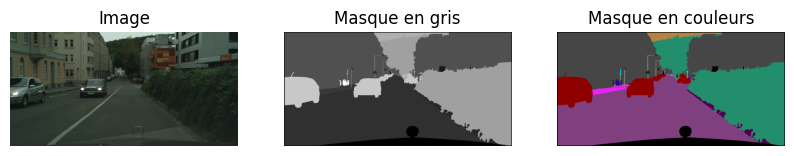

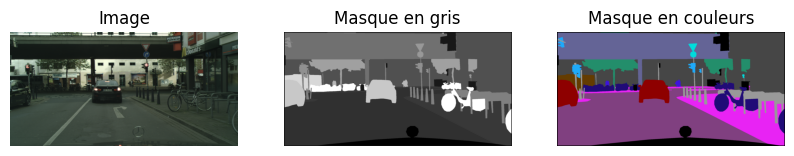

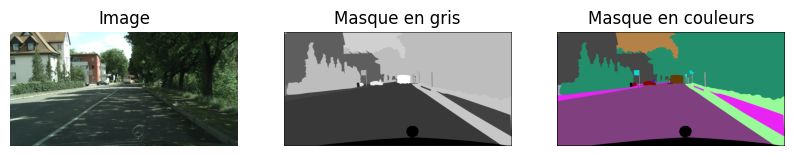

In [19]:
show_random_images_with_masks(df_train, n=3)

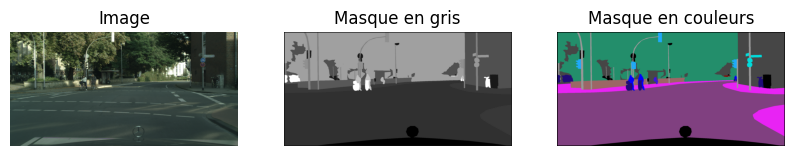

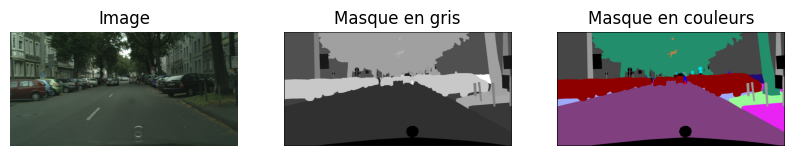

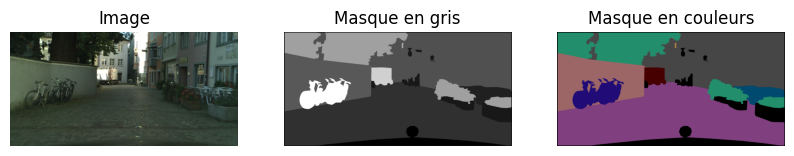

In [20]:
show_random_images_with_masks(df_val, n=3)

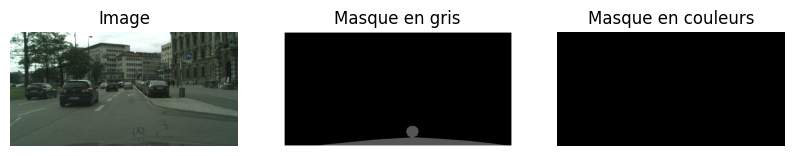

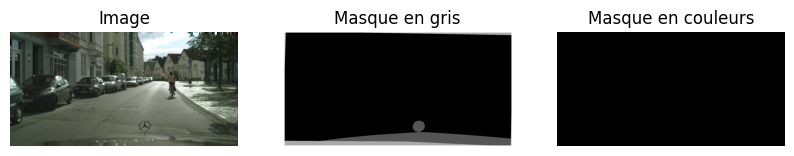

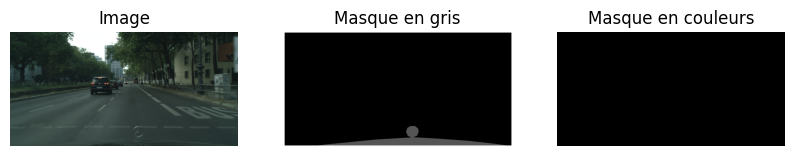

In [21]:
show_random_images_with_masks(df_test, n=3)

In [22]:
image0 = cv2.imread(df_train.iloc[0,0])
mask0 = cv2.imread(df_train.iloc[0,1])

print('Dimension image :', image0.shape)
print('Dimension mask :', mask0.shape)

Dimension image : (1024, 2048, 3)
Dimension mask : (1024, 2048, 3)


In [23]:
df_train_sample = df_train.sample(n=300, random_state=42)

# Catégories

In [24]:
cats = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
}

In [25]:
# Création d'une carte de catégories pour les masques
cat_map = {}
for i, (cat, ids) in enumerate(cats.items()):
    for id_ in ids:
        cat_map[id_] = i

# Entrainement avec VGG16

## Avec 10 époques

In [26]:
### Chargement des données
images = load_images(df_train_sample)  # Charger les images
masks = load_masks(df_train_sample)    # Charger les masques

# Construction du modèle de segmentation
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 512, 3))

# Utilisation de la sortie d'un bloc intermédiaire pour conserver des détails spatiaux
layer_dict = dict([(layer.name, layer) for layer in base_model.layers])
x = layer_dict['block5_conv3'].output

# Ajout de couches de déconvolution pour la segmentation
x = UpSampling2D((2, 2))(x)
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)

# Dernière couche pour le nombre de classes
output = Conv2D(len(cats), (1, 1), padding='same', activation='softmax')(x)

# Définition du modèle final
model = Model(inputs=base_model.input, outputs=output)

# Compilation du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[dice_coeff, dice_loss, total_loss, jaccard_score, 'accuracy'])

# Entraînement du modèle avec le callback
# history = model.fit(
#     images,
#     masks,
#     batch_size=8,
#     epochs=10,
#     validation_split=0.2,
#     callbacks=[PredictionCallback()]
# )

## Avec 20 époques

In [27]:
filename = f"best_model_without_data_augmentation.keras"

# Définition du callback ModelCheckpoint 
model_checkpoint = ModelCheckpoint(
    filepath=filename,
    monitor='val_jaccard_score',
    mode='max',
    save_best_only=True,
    verbose=1
)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.2325 - dice_coeff: 0.1634 - dice_loss: 0.8366 - jaccard_score: 0.0904 - loss: 5.3724 - total_loss: 4.9399 
Epoch 1: val_jaccard_score improved from -inf to 0.19252, saving model to best_model_without_data_augmentation.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


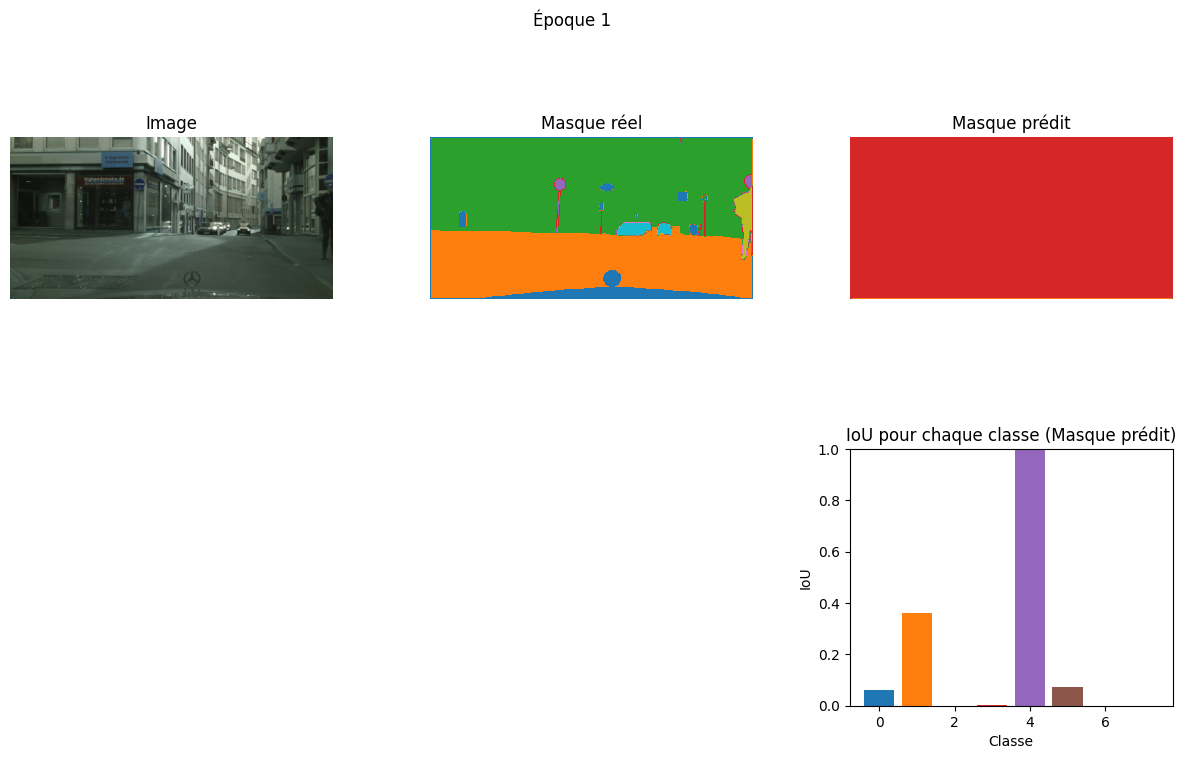

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.0608
Classe 1 : IoU = 0.3603
Classe 2 : IoU = 0.0000
Classe 3 : IoU = 0.0011
Classe 4 : IoU = 1.0000
Classe 5 : IoU = 0.0714
Classe 6 : IoU = 0.0005
Classe 7 : IoU = 0.0007
30/30 ━━━━━━━━━━━━━━━━━━━━ 489s 16s/step - accuracy: 0.2349 - dice_coeff: 0.1634 - dice_loss: 0.8366 - jaccard_score: 0.0904 - loss: 5.3069 - total_loss: 4.9106 - val_accuracy: 0.3771 - val_dice_coeff: 0.3226 - val_dice_loss: 0.6774 - val_jaccard_score: 0.1925 - val_loss: 2.5948 - val_total_loss: 3.9687
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.3259 - dice_coeff: 0.2357 - dice_loss: 0.7643 - jaccard_score: 0.1356 - loss: 1.8225 - total_loss: 3.4115 
Epoch 2: val_jaccard_score did not improve from 0.19252
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


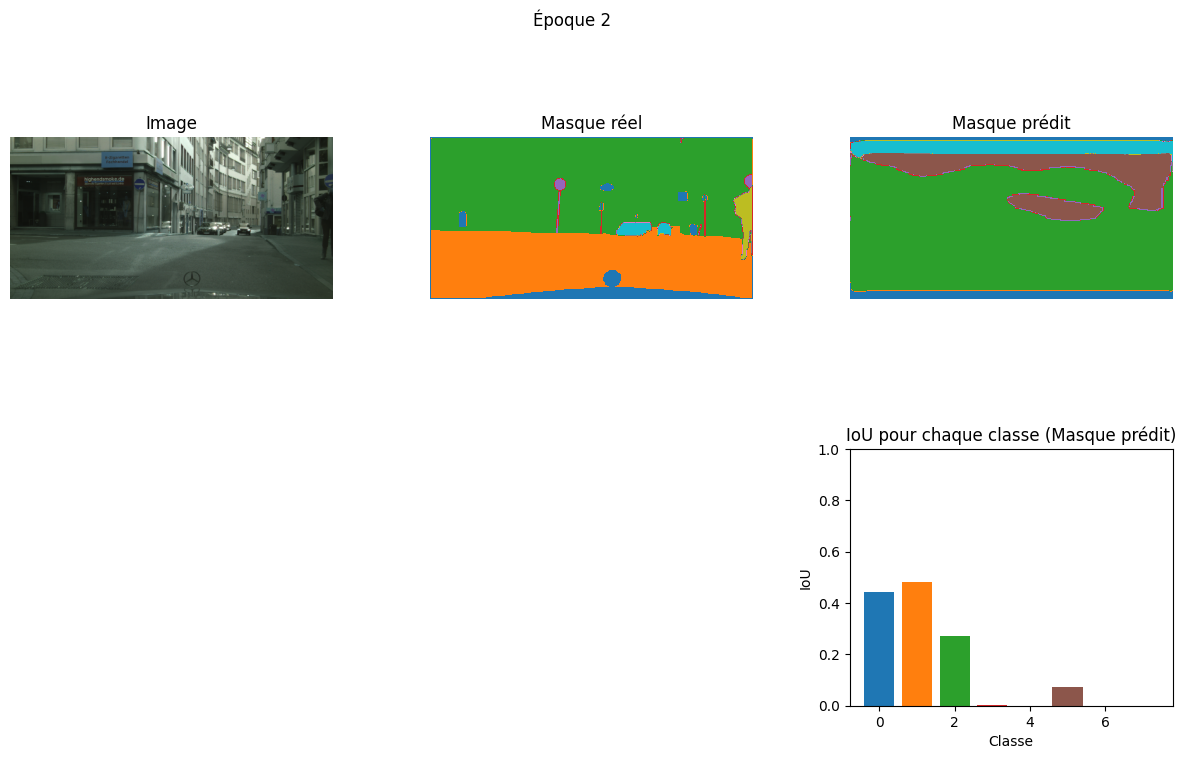

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.4437
Classe 1 : IoU = 0.4817
Classe 2 : IoU = 0.2710
Classe 3 : IoU = 0.0011
Classe 4 : IoU = 0.0001
Classe 5 : IoU = 0.0714
Classe 6 : IoU = 0.0005
Classe 7 : IoU = 0.0007
30/30 ━━━━━━━━━━━━━━━━━━━━ 538s 18s/step - accuracy: 0.3276 - dice_coeff: 0.2366 - dice_loss: 0.7634 - jaccard_score: 0.1361 - loss: 1.8175 - total_loss: 3.4092 - val_accuracy: 0.5284 - val_dice_coeff: 0.3196 - val_dice_loss: 0.6804 - val_jaccard_score: 0.1903 - val_loss: 1.4651 - val_total_loss: 3.2434
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.5313 - dice_coeff: 0.3853 - dice_loss: 0.6147 - jaccard_score: 0.2411 - loss: 1.3505 - total_loss: 3.1368 
Epoch 3: val_jaccard_score improved from 0.19252 to 0.33961, saving model to best_model_without_data_augmentation.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


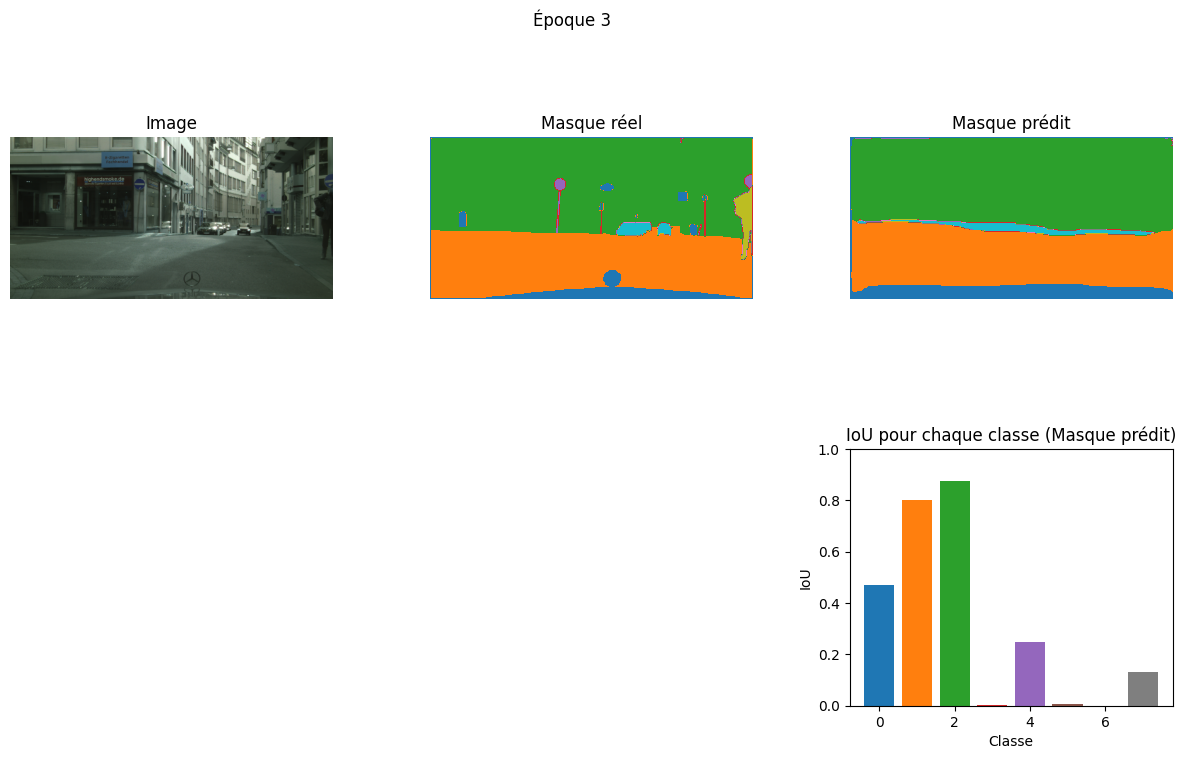

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.4710
Classe 1 : IoU = 0.8019
Classe 2 : IoU = 0.8742
Classe 3 : IoU = 0.0011
Classe 4 : IoU = 0.2500
Classe 5 : IoU = 0.0074
Classe 6 : IoU = 0.0005
Classe 7 : IoU = 0.1302
30/30 ━━━━━━━━━━━━━━━━━━━━ 536s 18s/step - accuracy: 0.5327 - dice_coeff: 0.3872 - dice_loss: 0.6128 - jaccard_score: 0.2427 - loss: 1.3455 - total_loss: 3.1345 - val_accuracy: 0.6032 - val_dice_coeff: 0.5067 - val_dice_loss: 0.4933 - val_jaccard_score: 0.3396 - val_loss: 1.0392 - val_total_loss: 3.1398
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.6266 - dice_coeff: 0.5293 - dice_loss: 0.4707 - jaccard_score: 0.3603 - loss: 0.9621 - total_loss: 3.0564 
Epoch 4: val_jaccard_score improved from 0.33961 to 0.37140, saving model to best_model_without_data_augmentation.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


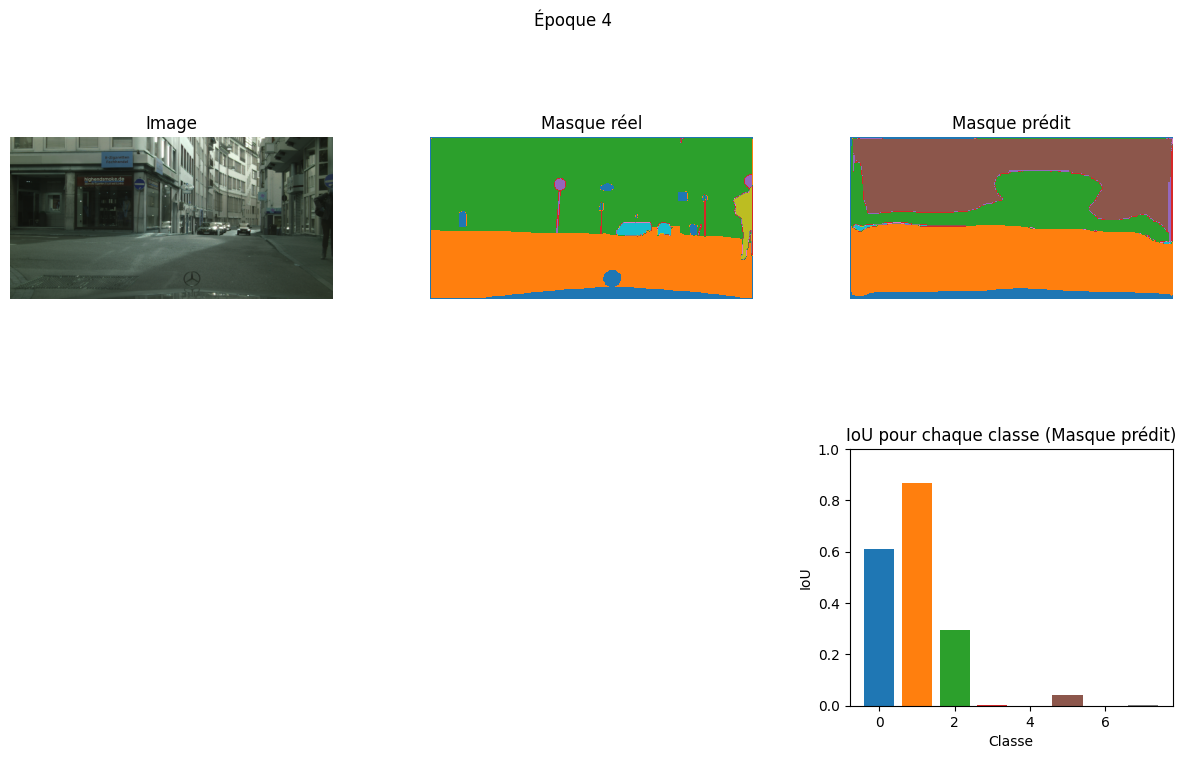

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.6089
Classe 1 : IoU = 0.8678
Classe 2 : IoU = 0.2950
Classe 3 : IoU = 0.0011
Classe 4 : IoU = 0.0000
Classe 5 : IoU = 0.0417
Classe 6 : IoU = 0.0005
Classe 7 : IoU = 0.0034
30/30 ━━━━━━━━━━━━━━━━━━━━ 538s 18s/step - accuracy: 0.6267 - dice_coeff: 0.5297 - dice_loss: 0.4703 - jaccard_score: 0.3606 - loss: 0.9615 - total_loss: 3.0560 - val_accuracy: 0.6031 - val_dice_coeff: 0.5413 - val_dice_loss: 0.4587 - val_jaccard_score: 0.3714 - val_loss: 0.9579 - val_total_loss: 2.9544
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.6508 - dice_coeff: 0.5675 - dice_loss: 0.4325 - jaccard_score: 0.3969 - loss: 0.8848 - total_loss: 3.0429 
Epoch 5: val_jaccard_score improved from 0.37140 to 0.40252, saving model to best_model_without_data_augmentation.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


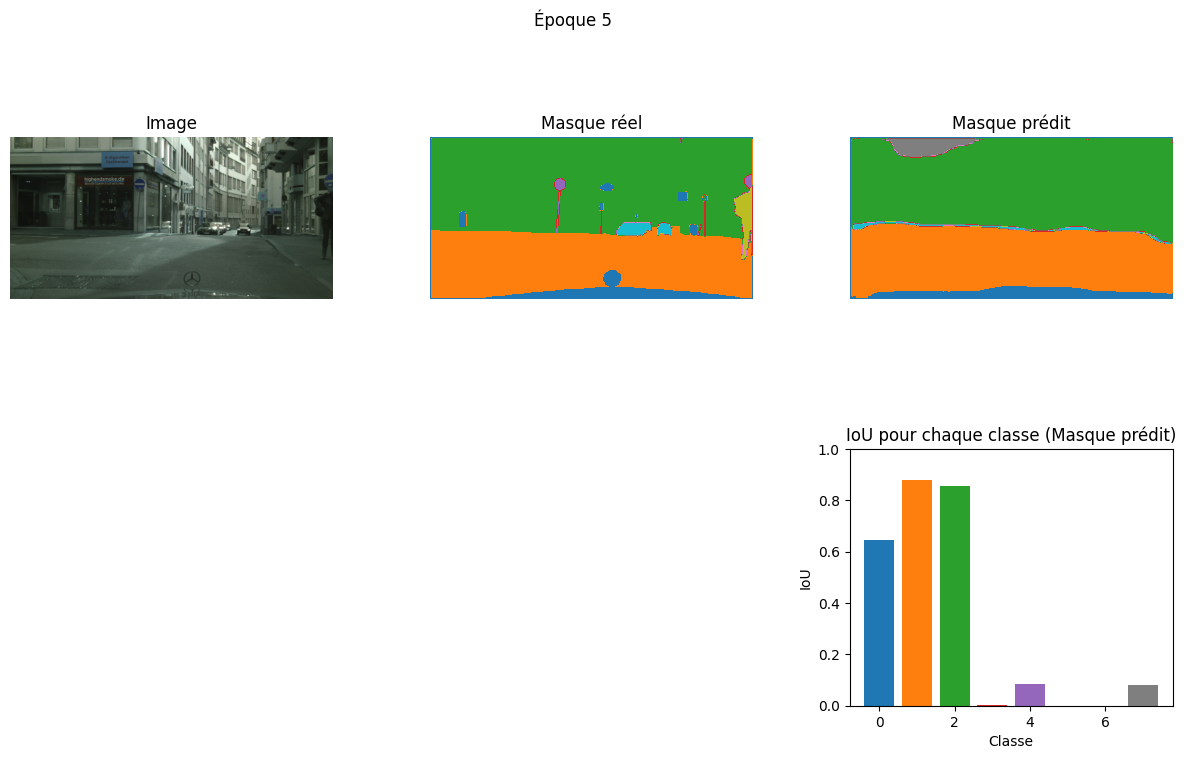

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.6439
Classe 1 : IoU = 0.8778
Classe 2 : IoU = 0.8552
Classe 3 : IoU = 0.0011
Classe 4 : IoU = 0.0833
Classe 5 : IoU = 0.0003
Classe 6 : IoU = 0.0005
Classe 7 : IoU = 0.0823
30/30 ━━━━━━━━━━━━━━━━━━━━ 542s 18s/step - accuracy: 0.6510 - dice_coeff: 0.5674 - dice_loss: 0.4326 - jaccard_score: 0.3968 - loss: 0.8851 - total_loss: 3.0421 - val_accuracy: 0.6412 - val_dice_coeff: 0.5736 - val_dice_loss: 0.4264 - val_jaccard_score: 0.4025 - val_loss: 0.9232 - val_total_loss: 2.9871
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.6782 - dice_coeff: 0.5931 - dice_loss: 0.4069 - jaccard_score: 0.4219 - loss: 0.8249 - total_loss: 2.9605 
Epoch 6: val_jaccard_score did not improve from 0.40252
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


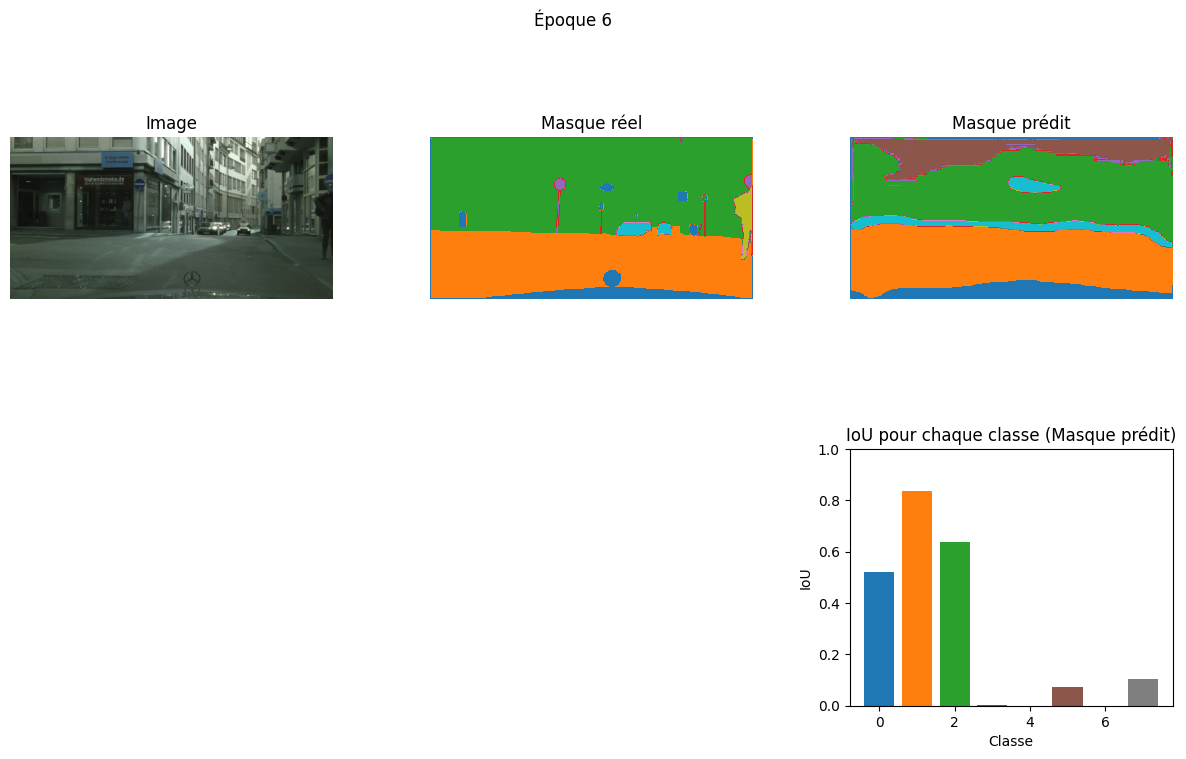

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.5205
Classe 1 : IoU = 0.8350
Classe 2 : IoU = 0.6365
Classe 3 : IoU = 0.0011
Classe 4 : IoU = 0.0001
Classe 5 : IoU = 0.0714
Classe 6 : IoU = 0.0005
Classe 7 : IoU = 0.1032
30/30 ━━━━━━━━━━━━━━━━━━━━ 544s 18s/step - accuracy: 0.6781 - dice_coeff: 0.5929 - dice_loss: 0.4071 - jaccard_score: 0.4217 - loss: 0.8255 - total_loss: 2.9615 - val_accuracy: 0.6524 - val_dice_coeff: 0.5597 - val_dice_loss: 0.4403 - val_jaccard_score: 0.3888 - val_loss: 0.8504 - val_total_loss: 2.9073
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.6649 - dice_coeff: 0.5886 - dice_loss: 0.4114 - jaccard_score: 0.4173 - loss: 0.8092 - total_loss: 2.9240 
Epoch 7: val_jaccard_score improved from 0.40252 to 0.41691, saving model to best_model_without_data_augmentation.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


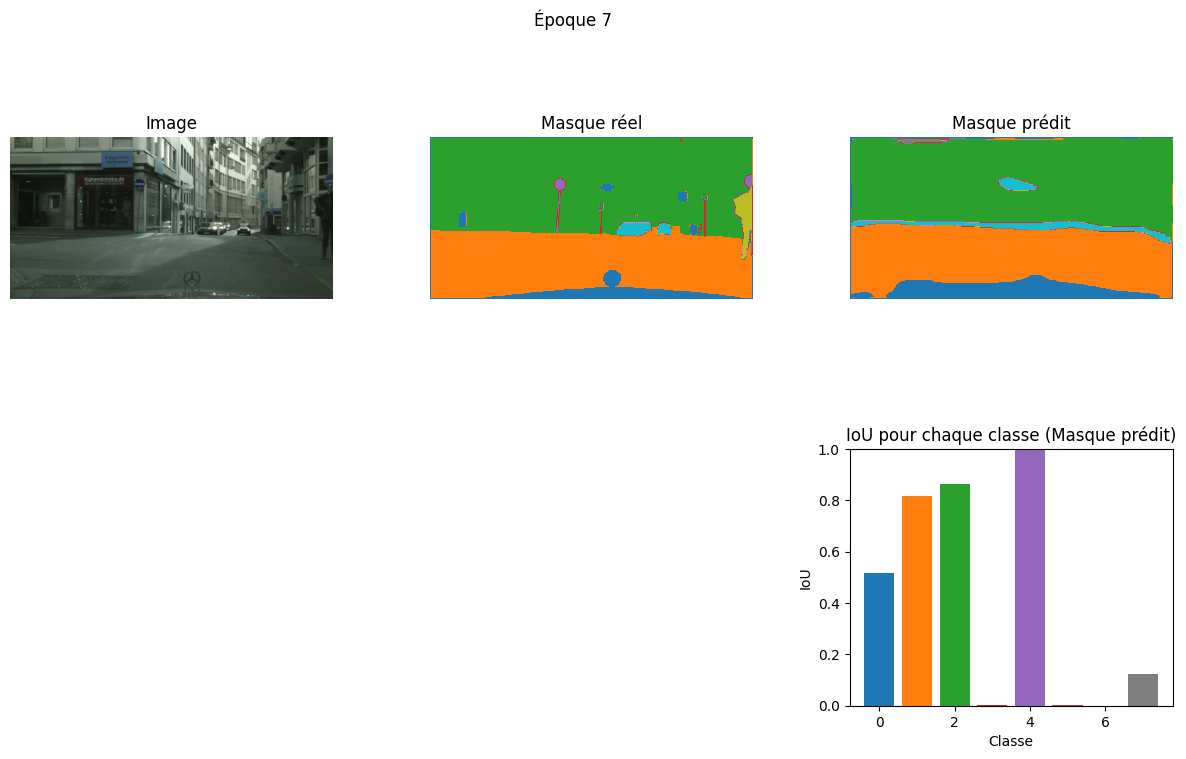

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.5155
Classe 1 : IoU = 0.8154
Classe 2 : IoU = 0.8619
Classe 3 : IoU = 0.0011
Classe 4 : IoU = 1.0000
Classe 5 : IoU = 0.0018
Classe 6 : IoU = 0.0005
Classe 7 : IoU = 0.1252
30/30 ━━━━━━━━━━━━━━━━━━━━ 546s 18s/step - accuracy: 0.6652 - dice_coeff: 0.5889 - dice_loss: 0.4111 - jaccard_score: 0.4176 - loss: 0.8089 - total_loss: 2.9263 - val_accuracy: 0.6646 - val_dice_coeff: 0.5882 - val_dice_loss: 0.4118 - val_jaccard_score: 0.4169 - val_loss: 0.8479 - val_total_loss: 3.1321
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.6896 - dice_coeff: 0.6093 - dice_loss: 0.3907 - jaccard_score: 0.4383 - loss: 0.7726 - total_loss: 3.0461 
Epoch 8: val_jaccard_score did not improve from 0.41691
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


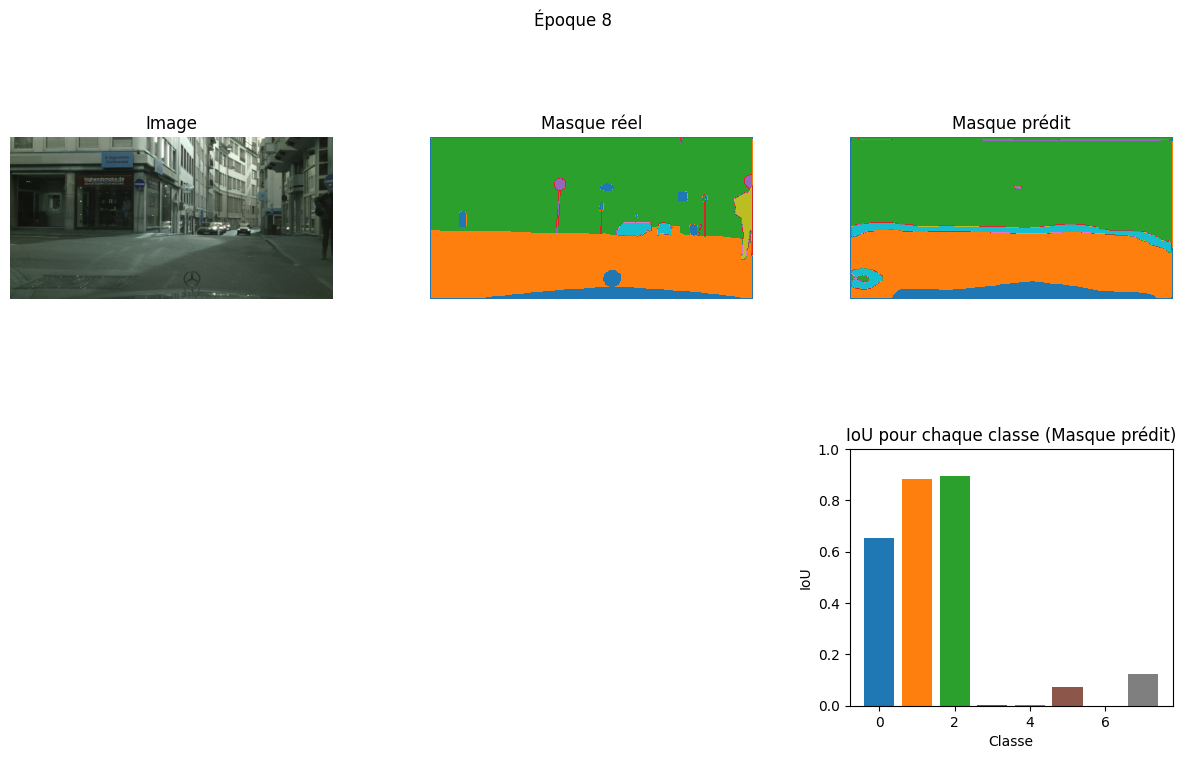

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.6547
Classe 1 : IoU = 0.8852
Classe 2 : IoU = 0.8965
Classe 3 : IoU = 0.0011
Classe 4 : IoU = 0.0018
Classe 5 : IoU = 0.0714
Classe 6 : IoU = 0.0005
Classe 7 : IoU = 0.1227
30/30 ━━━━━━━━━━━━━━━━━━━━ 545s 18s/step - accuracy: 0.6896 - dice_coeff: 0.6093 - dice_loss: 0.3907 - jaccard_score: 0.4383 - loss: 0.7726 - total_loss: 3.0459 - val_accuracy: 0.6707 - val_dice_coeff: 0.5857 - val_dice_loss: 0.4143 - val_jaccard_score: 0.4143 - val_loss: 0.8259 - val_total_loss: 3.0415
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.6880 - dice_coeff: 0.6055 - dice_loss: 0.3945 - jaccard_score: 0.4347 - loss: 0.7967 - total_loss: 3.0926 
Epoch 9: val_jaccard_score improved from 0.41691 to 0.41855, saving model to best_model_without_data_augmentation.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


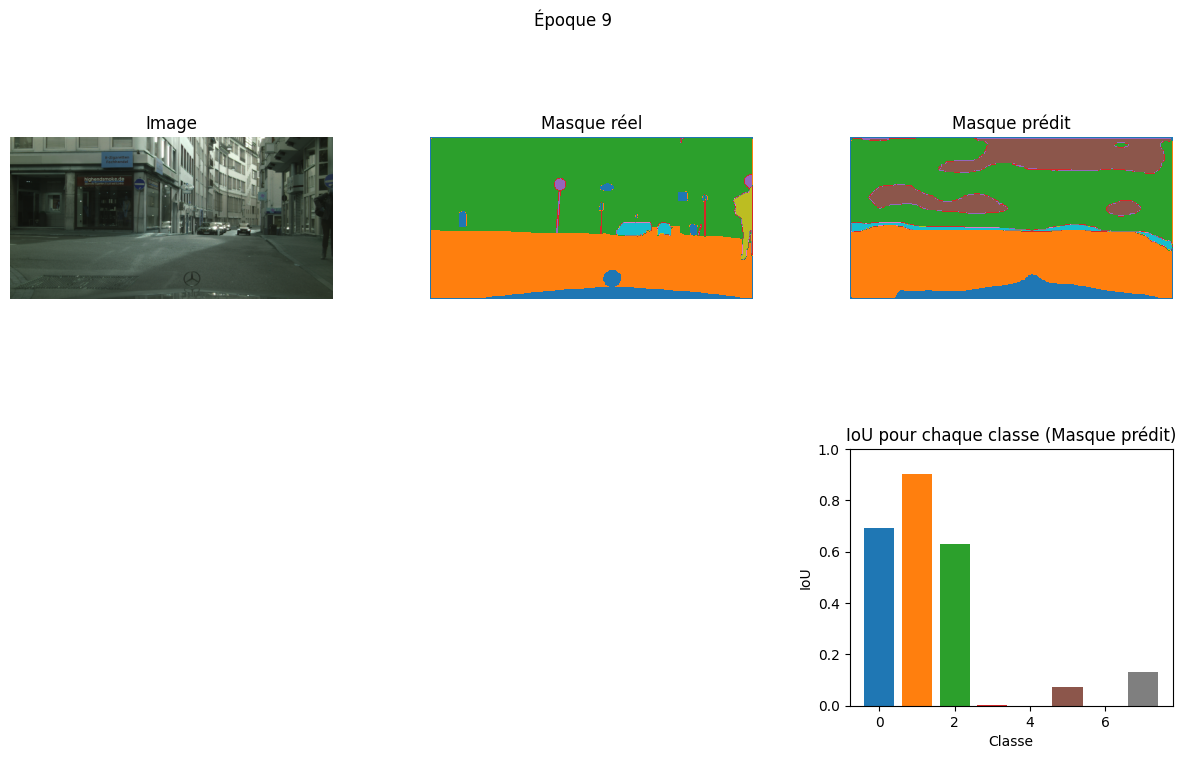

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.6935
Classe 1 : IoU = 0.9022
Classe 2 : IoU = 0.6318
Classe 3 : IoU = 0.0011
Classe 4 : IoU = 0.0000
Classe 5 : IoU = 0.0714
Classe 6 : IoU = 0.0005
Classe 7 : IoU = 0.1314
30/30 ━━━━━━━━━━━━━━━━━━━━ 541s 18s/step - accuracy: 0.6879 - dice_coeff: 0.6055 - dice_loss: 0.3945 - jaccard_score: 0.4347 - loss: 0.7965 - total_loss: 3.0917 - val_accuracy: 0.6837 - val_dice_coeff: 0.5898 - val_dice_loss: 0.4102 - val_jaccard_score: 0.4185 - val_loss: 0.8116 - val_total_loss: 3.0719
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.7022 - dice_coeff: 0.6155 - dice_loss: 0.3845 - jaccard_score: 0.4455 - loss: 0.7672 - total_loss: 3.0968 
Epoch 10: val_jaccard_score improved from 0.41855 to 0.44760, saving model to best_model_without_data_augmentation.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


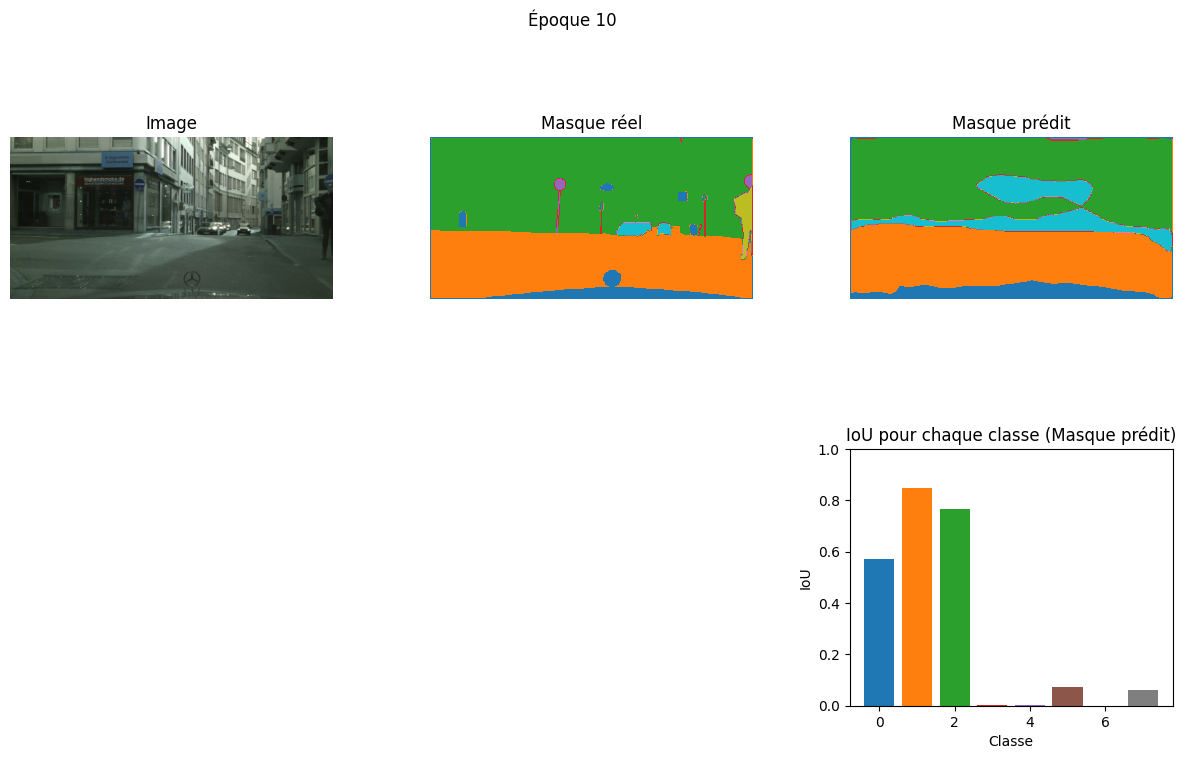

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.5708
Classe 1 : IoU = 0.8483
Classe 2 : IoU = 0.7679
Classe 3 : IoU = 0.0011
Classe 4 : IoU = 0.0040
Classe 5 : IoU = 0.0714
Classe 6 : IoU = 0.0005
Classe 7 : IoU = 0.0625
30/30 ━━━━━━━━━━━━━━━━━━━━ 551s 18s/step - accuracy: 0.7024 - dice_coeff: 0.6158 - dice_loss: 0.3842 - jaccard_score: 0.4457 - loss: 0.7665 - total_loss: 3.0976 - val_accuracy: 0.6831 - val_dice_coeff: 0.6182 - val_dice_loss: 0.3818 - val_jaccard_score: 0.4476 - val_loss: 0.8070 - val_total_loss: 3.2827
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.7253 - dice_coeff: 0.6385 - dice_loss: 0.3615 - jaccard_score: 0.4693 - loss: 0.7354 - total_loss: 3.2146 
Epoch 11: val_jaccard_score did not improve from 0.44760
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


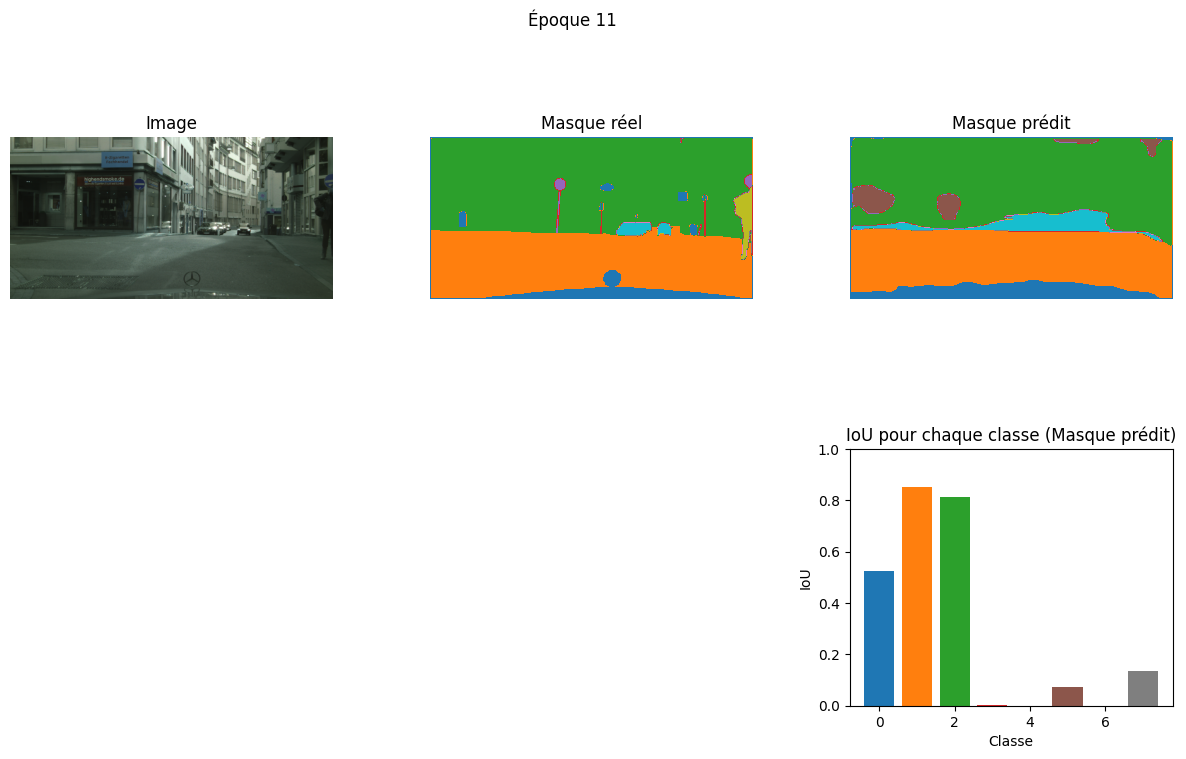

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.5246
Classe 1 : IoU = 0.8514
Classe 2 : IoU = 0.8113
Classe 3 : IoU = 0.0011
Classe 4 : IoU = 0.0002
Classe 5 : IoU = 0.0714
Classe 6 : IoU = 0.0005
Classe 7 : IoU = 0.1341
30/30 ━━━━━━━━━━━━━━━━━━━━ 550s 18s/step - accuracy: 0.7256 - dice_coeff: 0.6386 - dice_loss: 0.3614 - jaccard_score: 0.4694 - loss: 0.7355 - total_loss: 3.2137 - val_accuracy: 0.7551 - val_dice_coeff: 0.6125 - val_dice_loss: 0.3875 - val_jaccard_score: 0.4418 - val_loss: 0.7324 - val_total_loss: 2.9014
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.7650 - dice_coeff: 0.6569 - dice_loss: 0.3431 - jaccard_score: 0.4895 - loss: 0.6932 - total_loss: 2.9965 
Epoch 12: val_jaccard_score improved from 0.44760 to 0.51052, saving model to best_model_without_data_augmentation.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


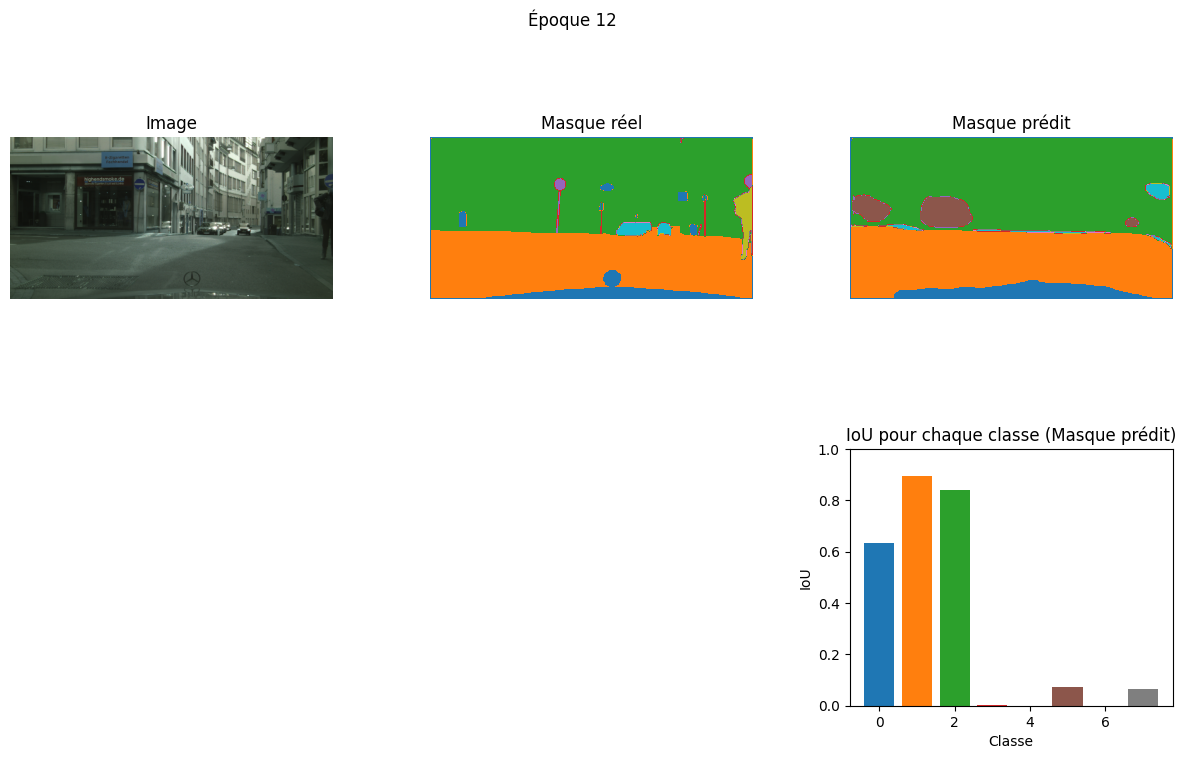

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.6328
Classe 1 : IoU = 0.8953
Classe 2 : IoU = 0.8415
Classe 3 : IoU = 0.0011
Classe 4 : IoU = 0.0002
Classe 5 : IoU = 0.0714
Classe 6 : IoU = 0.0005
Classe 7 : IoU = 0.0656
30/30 ━━━━━━━━━━━━━━━━━━━━ 555s 19s/step - accuracy: 0.7650 - dice_coeff: 0.6572 - dice_loss: 0.3428 - jaccard_score: 0.4898 - loss: 0.6933 - total_loss: 2.9973 - val_accuracy: 0.7772 - val_dice_coeff: 0.6756 - val_dice_loss: 0.3244 - val_jaccard_score: 0.5105 - val_loss: 0.7010 - val_total_loss: 3.1085
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.7957 - dice_coeff: 0.7012 - dice_loss: 0.2988 - jaccard_score: 0.5406 - loss: 0.6324 - total_loss: 2.9991 
Epoch 13: val_jaccard_score improved from 0.51052 to 0.52428, saving model to best_model_without_data_augmentation.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


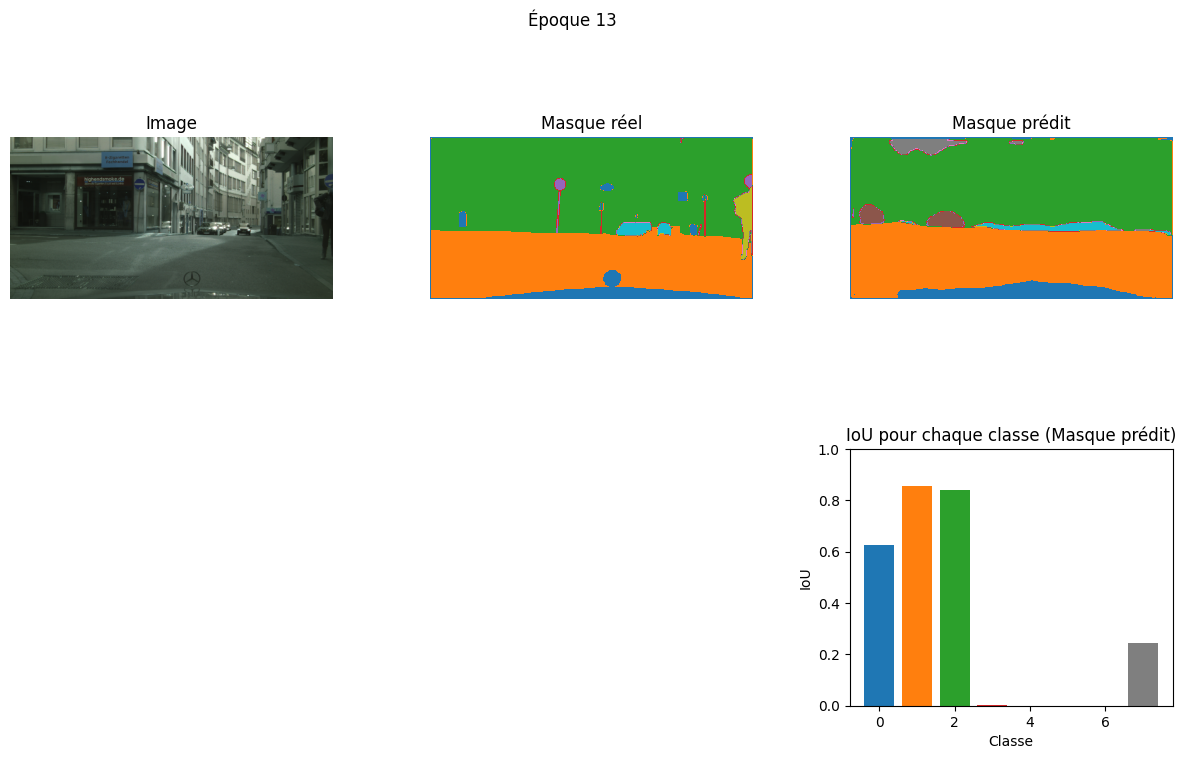

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.6279
Classe 1 : IoU = 0.8580
Classe 2 : IoU = 0.8390
Classe 3 : IoU = 0.0011
Classe 4 : IoU = 0.0005
Classe 5 : IoU = 0.0005
Classe 6 : IoU = 0.0005
Classe 7 : IoU = 0.2448
30/30 ━━━━━━━━━━━━━━━━━━━━ 540s 18s/step - accuracy: 0.7957 - dice_coeff: 0.7013 - dice_loss: 0.2987 - jaccard_score: 0.5408 - loss: 0.6323 - total_loss: 2.9981 - val_accuracy: 0.7868 - val_dice_coeff: 0.6876 - val_dice_loss: 0.3124 - val_jaccard_score: 0.5243 - val_loss: 0.6923 - val_total_loss: 3.0130
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.7786 - dice_coeff: 0.6857 - dice_loss: 0.3143 - jaccard_score: 0.5229 - loss: 0.6820 - total_loss: 2.9935 
Epoch 14: val_jaccard_score improved from 0.52428 to 0.53674, saving model to best_model_without_data_augmentation.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


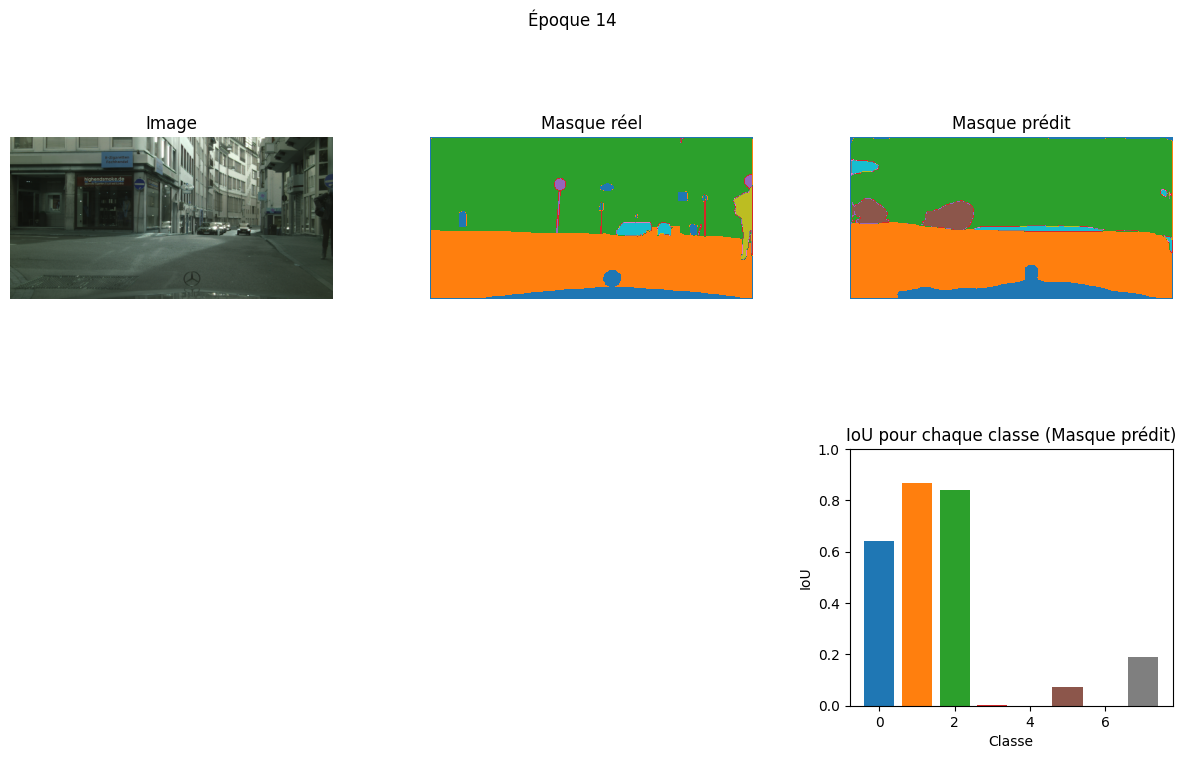

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.6435
Classe 1 : IoU = 0.8688
Classe 2 : IoU = 0.8415
Classe 3 : IoU = 0.0011
Classe 4 : IoU = 0.0002
Classe 5 : IoU = 0.0714
Classe 6 : IoU = 0.0005
Classe 7 : IoU = 0.1905
30/30 ━━━━━━━━━━━━━━━━━━━━ 539s 18s/step - accuracy: 0.7787 - dice_coeff: 0.6858 - dice_loss: 0.3142 - jaccard_score: 0.5230 - loss: 0.6817 - total_loss: 2.9917 - val_accuracy: 0.7868 - val_dice_coeff: 0.6983 - val_dice_loss: 0.3017 - val_jaccard_score: 0.5367 - val_loss: 0.6837 - val_total_loss: 2.7929
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8066 - dice_coeff: 0.7168 - dice_loss: 0.2832 - jaccard_score: 0.5594 - loss: 0.5981 - total_loss: 2.8736 
Epoch 15: val_jaccard_score improved from 0.53674 to 0.54851, saving model to best_model_without_data_augmentation.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


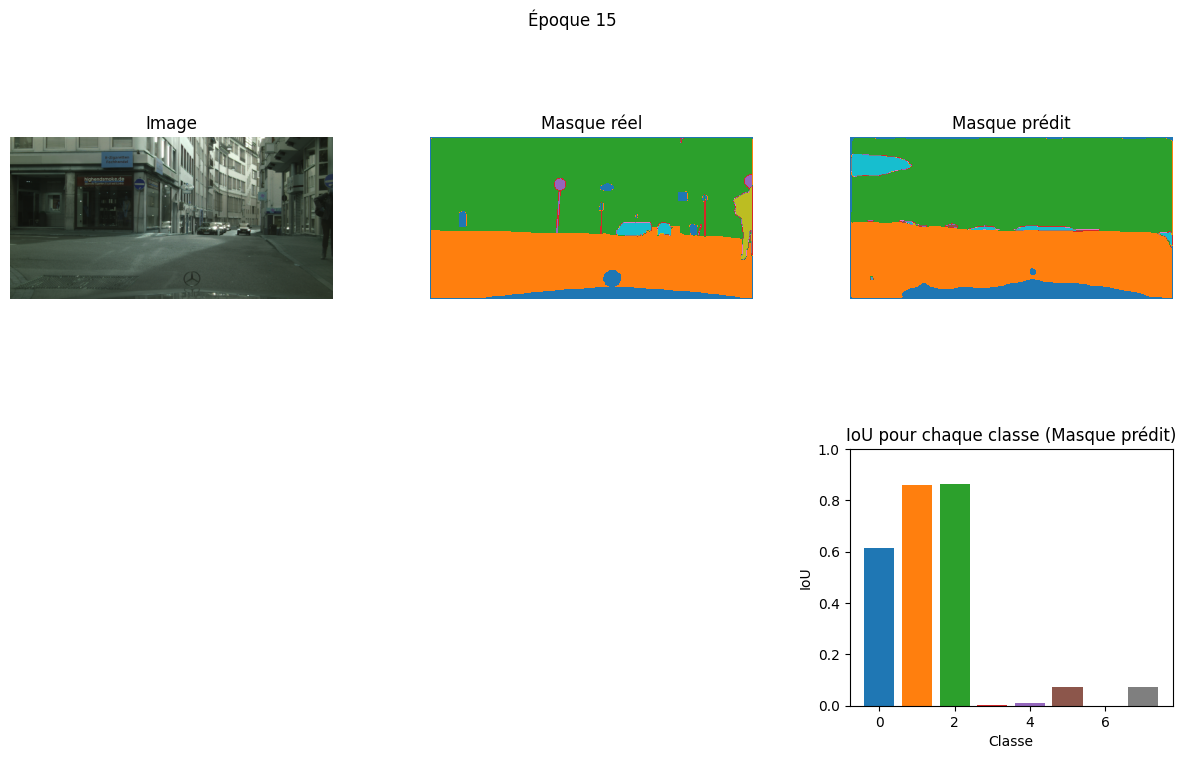

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.6137
Classe 1 : IoU = 0.8592
Classe 2 : IoU = 0.8644
Classe 3 : IoU = 0.0011
Classe 4 : IoU = 0.0120
Classe 5 : IoU = 0.0714
Classe 6 : IoU = 0.0005
Classe 7 : IoU = 0.0724
30/30 ━━━━━━━━━━━━━━━━━━━━ 540s 18s/step - accuracy: 0.8061 - dice_coeff: 0.7164 - dice_loss: 0.2836 - jaccard_score: 0.5589 - loss: 0.5991 - total_loss: 2.8762 - val_accuracy: 0.8021 - val_dice_coeff: 0.7082 - val_dice_loss: 0.2918 - val_jaccard_score: 0.5485 - val_loss: 0.6324 - val_total_loss: 2.8853
Epoch 16/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8200 - dice_coeff: 0.7347 - dice_loss: 0.2653 - jaccard_score: 0.5812 - loss: 0.5711 - total_loss: 2.8420 
Epoch 16: val_jaccard_score improved from 0.54851 to 0.57550, saving model to best_model_without_data_augmentation.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


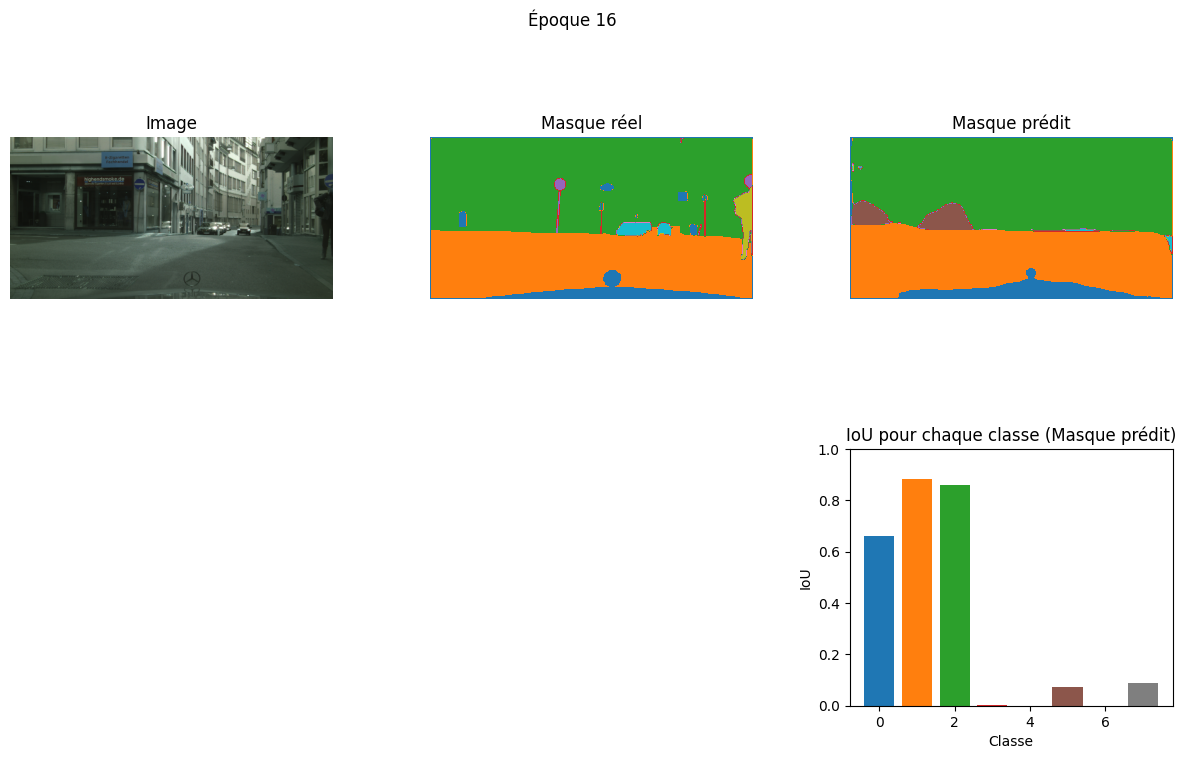

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.6623
Classe 1 : IoU = 0.8822
Classe 2 : IoU = 0.8611
Classe 3 : IoU = 0.0011
Classe 4 : IoU = 0.0002
Classe 5 : IoU = 0.0714
Classe 6 : IoU = 0.0005
Classe 7 : IoU = 0.0890
30/30 ━━━━━━━━━━━━━━━━━━━━ 545s 18s/step - accuracy: 0.8200 - dice_coeff: 0.7348 - dice_loss: 0.2652 - jaccard_score: 0.5814 - loss: 0.5710 - total_loss: 2.8437 - val_accuracy: 0.8067 - val_dice_coeff: 0.7303 - val_dice_loss: 0.2697 - val_jaccard_score: 0.5755 - val_loss: 0.6292 - val_total_loss: 2.9927
Epoch 17/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8263 - dice_coeff: 0.7474 - dice_loss: 0.2526 - jaccard_score: 0.5972 - loss: 0.5476 - total_loss: 2.9440 
Epoch 17: val_jaccard_score improved from 0.57550 to 0.60404, saving model to best_model_without_data_augmentation.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


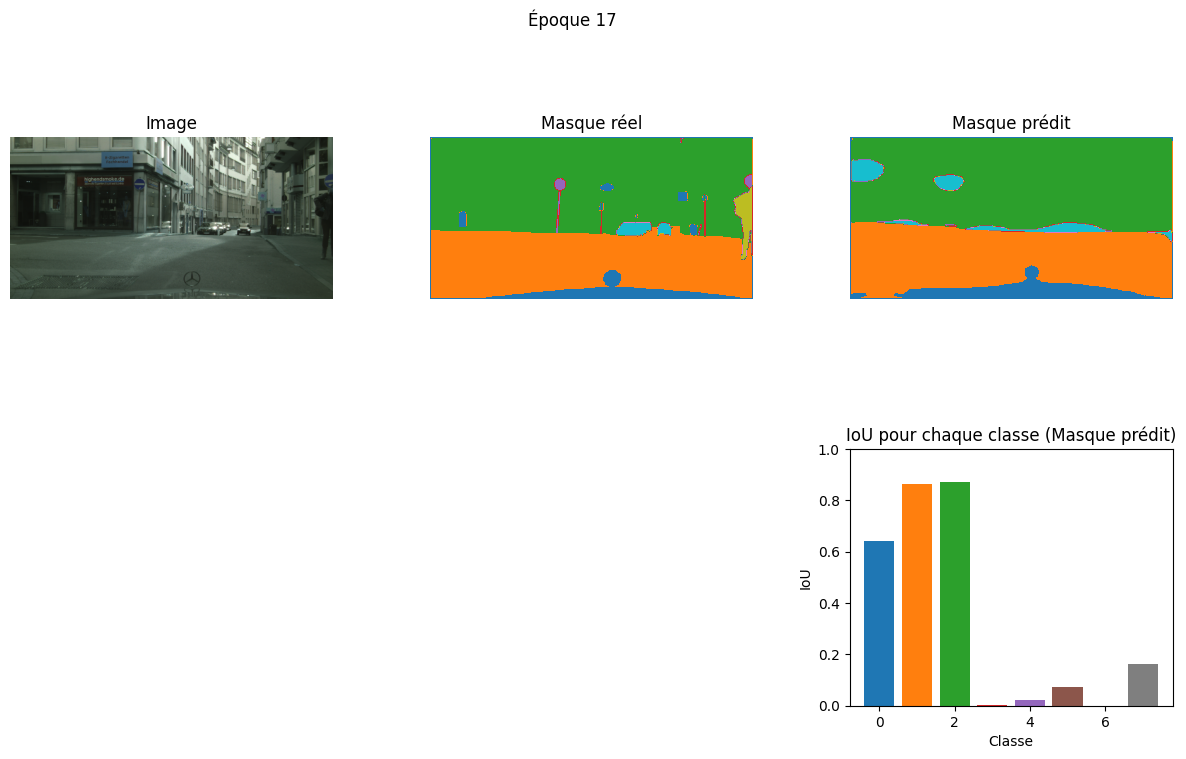

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.6420
Classe 1 : IoU = 0.8635
Classe 2 : IoU = 0.8708
Classe 3 : IoU = 0.0011
Classe 4 : IoU = 0.0213
Classe 5 : IoU = 0.0714
Classe 6 : IoU = 0.0005
Classe 7 : IoU = 0.1626
30/30 ━━━━━━━━━━━━━━━━━━━━ 541s 18s/step - accuracy: 0.8264 - dice_coeff: 0.7476 - dice_loss: 0.2524 - jaccard_score: 0.5974 - loss: 0.5471 - total_loss: 2.9433 - val_accuracy: 0.8142 - val_dice_coeff: 0.7529 - val_dice_loss: 0.2471 - val_jaccard_score: 0.6040 - val_loss: 0.6395 - val_total_loss: 3.2523
Epoch 18/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8320 - dice_coeff: 0.7572 - dice_loss: 0.2428 - jaccard_score: 0.6098 - loss: 0.5399 - total_loss: 2.8801 
Epoch 18: val_jaccard_score improved from 0.60404 to 0.61307, saving model to best_model_without_data_augmentation.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


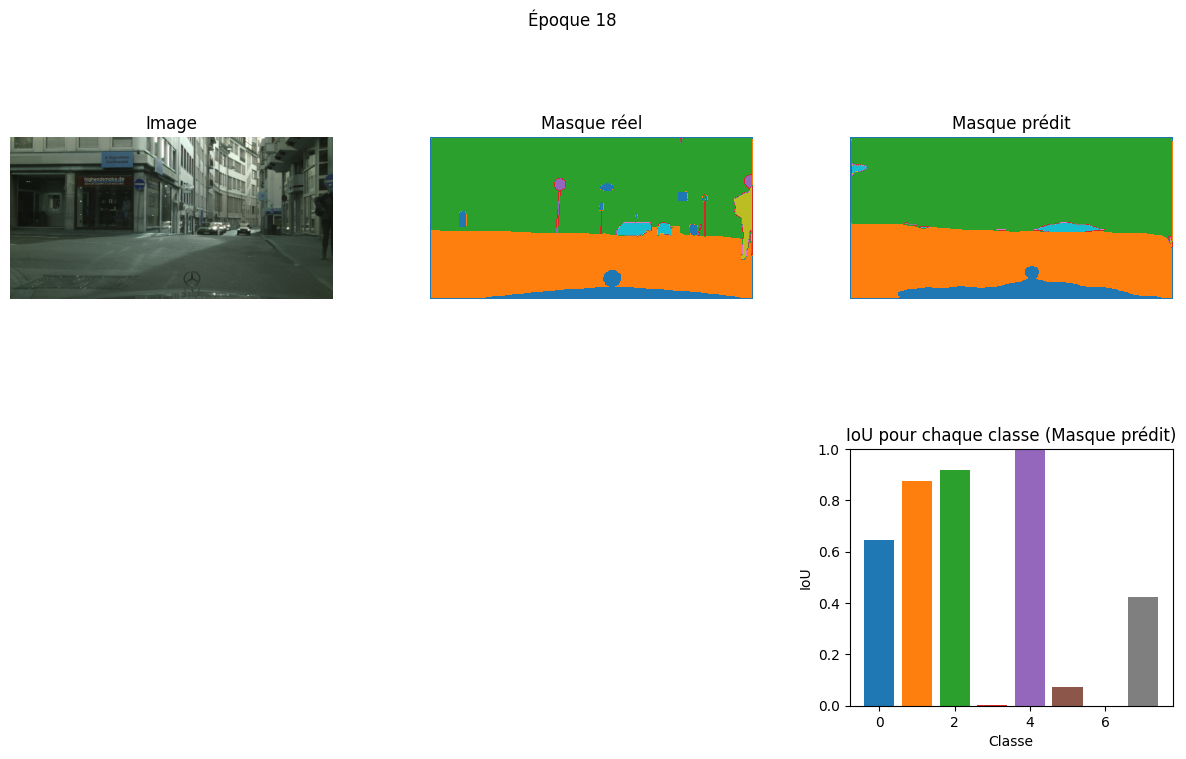

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.6466
Classe 1 : IoU = 0.8758
Classe 2 : IoU = 0.9165
Classe 3 : IoU = 0.0011
Classe 4 : IoU = 1.0000
Classe 5 : IoU = 0.0714
Classe 6 : IoU = 0.0005
Classe 7 : IoU = 0.4242
30/30 ━━━━━━━━━━━━━━━━━━━━ 534s 18s/step - accuracy: 0.8322 - dice_coeff: 0.7573 - dice_loss: 0.2427 - jaccard_score: 0.6099 - loss: 0.5394 - total_loss: 2.8794 - val_accuracy: 0.8280 - val_dice_coeff: 0.7598 - val_dice_loss: 0.2402 - val_jaccard_score: 0.6131 - val_loss: 0.5565 - val_total_loss: 2.8457
Epoch 19/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8445 - dice_coeff: 0.7699 - dice_loss: 0.2301 - jaccard_score: 0.6264 - loss: 0.5005 - total_loss: 2.7795 
Epoch 19: val_jaccard_score improved from 0.61307 to 0.61903, saving model to best_model_without_data_augmentation.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


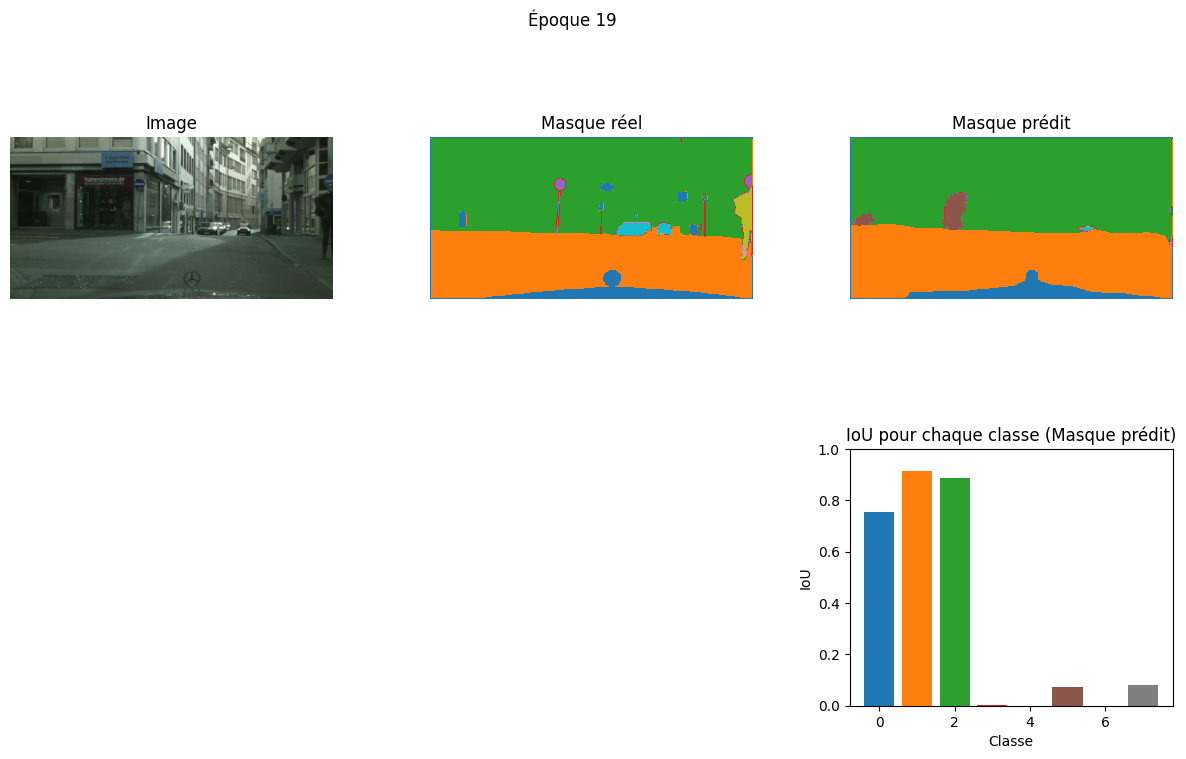

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.7557
Classe 1 : IoU = 0.9128
Classe 2 : IoU = 0.8867
Classe 3 : IoU = 0.0011
Classe 4 : IoU = 0.0005
Classe 5 : IoU = 0.0714
Classe 6 : IoU = 0.0005
Classe 7 : IoU = 0.0795
30/30 ━━━━━━━━━━━━━━━━━━━━ 539s 18s/step - accuracy: 0.8444 - dice_coeff: 0.7699 - dice_loss: 0.2301 - jaccard_score: 0.6264 - loss: 0.5007 - total_loss: 2.7808 - val_accuracy: 0.8261 - val_dice_coeff: 0.7644 - val_dice_loss: 0.2356 - val_jaccard_score: 0.6190 - val_loss: 0.5885 - val_total_loss: 3.0035
Epoch 20/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8538 - dice_coeff: 0.7815 - dice_loss: 0.2185 - jaccard_score: 0.6419 - loss: 0.4731 - total_loss: 2.8761 
Epoch 20: val_jaccard_score did not improve from 0.61903
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


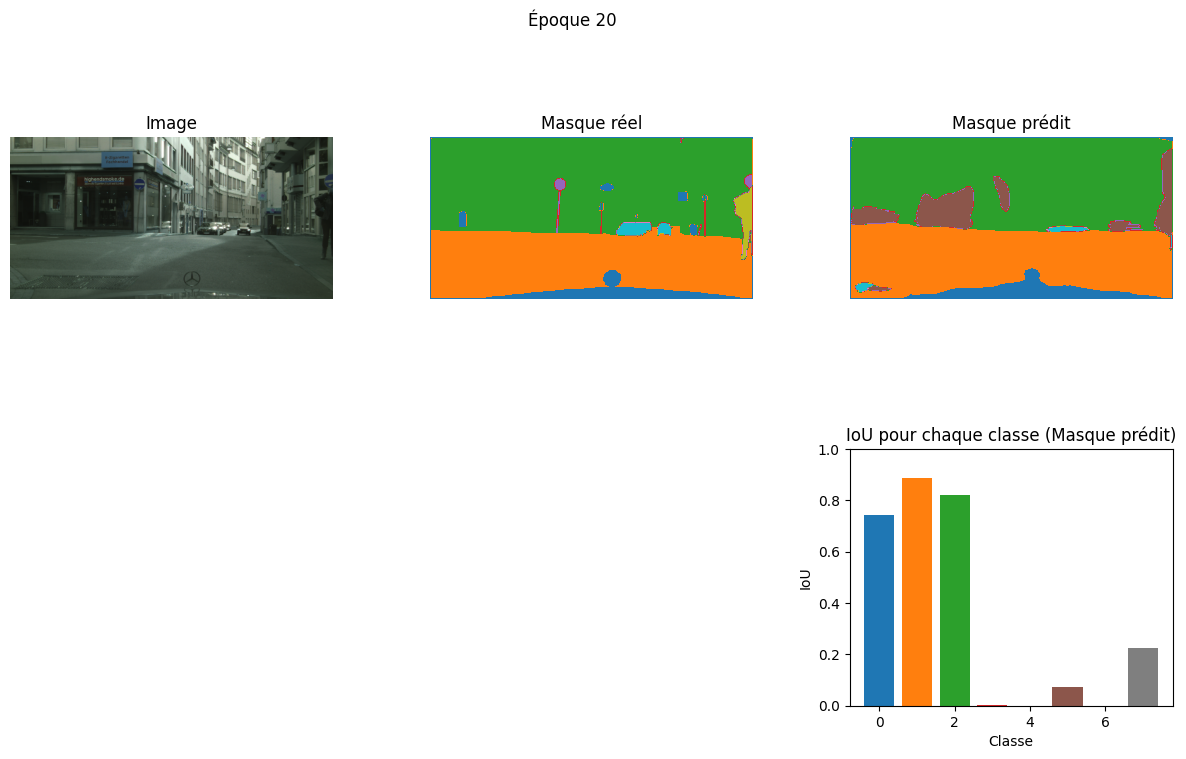

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.7438
Classe 1 : IoU = 0.8862
Classe 2 : IoU = 0.8208
Classe 3 : IoU = 0.0011
Classe 4 : IoU = 0.0001
Classe 5 : IoU = 0.0714
Classe 6 : IoU = 0.0005
Classe 7 : IoU = 0.2257
30/30 ━━━━━━━━━━━━━━━━━━━━ 542s 18s/step - accuracy: 0.8534 - dice_coeff: 0.7810 - dice_loss: 0.2190 - jaccard_score: 0.6413 - loss: 0.4743 - total_loss: 2.8757 - val_accuracy: 0.8047 - val_dice_coeff: 0.7068 - val_dice_loss: 0.2932 - val_jaccard_score: 0.5468 - val_loss: 0.6254 - val_total_loss: 2.7889
Restoring model weights from the end of the best epoch: 19.


In [28]:
# Chargement des données
images = load_images(df_train_sample)  # Charger les images
masks = load_masks(df_train_sample)    # Charger les masques

# Construction du modèle de segmentation
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 512, 3))

# Utilisation de la sortie d'un bloc intermédiaire pour conserver des détails spatiaux
layer_dict = dict([(layer.name, layer) for layer in base_model.layers])
x = layer_dict['block5_conv3'].output

# Ajout de couches de déconvolution pour la segmentation
x = UpSampling2D((2, 2))(x)
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)

# Dernière couche pour le nombre de classes
output = Conv2D(len(cats), (1, 1), padding='same', activation='softmax')(x)

# Définition du modèle final
model = Model(inputs=base_model.input, outputs=output)

# Compilation du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[dice_coeff, dice_loss, total_loss, jaccard_score, 'accuracy'])

# Entraînement du modèle avec le callback
history = model.fit(
    images,
    masks,
    batch_size=8,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint, PredictionCallback()]
)

# Data augmentation

## Avec Albumentations

### Fonctions

In [29]:
# Fonction de data augmentation avec albumentations
def augment_data_albumentations(df):
    images = load_images(df)
    masks = load_masks(df)
    
    # Définir les transformations avec redimensionnement
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),            # Flip horizontal avec probabilité 50%
        A.VerticalFlip(p=0.2),              # Flip vertical avec probabilité 20%
        A.Rotate(limit=10),                 # Rotation aléatoire entre -10 et 10 degrés
        A.RandomScale(scale_limit=0.2),     # Zoom de 80% à 120%
        A.Resize(256, 512)                  # Redimensionnement pour garantir une taille constante
    ])
    
    # Appliquer les transformations sur les images et masques
    images_aug, masks_aug = [], []
    for img, mask in zip(images, masks):
        augmented = transform(image=img, mask=mask)
        images_aug.append(augmented['image'])
        masks_aug.append(augmented['mask'])
    
    return np.array(images_aug), np.array(masks_aug)

In [30]:
# Fonction de data augmentation avec transformations supplémentaires
def augment_data_albumentations_extended(df):
    images = load_images(df)
    masks = load_masks(df)
    
    # Définir les transformations avec des manipulations supplémentaires
    transform = A.Compose([
        # Transformations de la première fonction
        A.HorizontalFlip(p=0.5),                # Flip horizontal avec probabilité 50%
        A.VerticalFlip(p=0.2),                  # Flip vertical avec probabilité 20%
        A.Rotate(limit=10),                     # Rotation aléatoire entre -10 et 10 degrés
        A.RandomScale(scale_limit=0.2),         # Zoom de 80% à 120%
        
        # Transformations supplémentaires
        A.RandomBrightnessContrast(p=0.2),      # Ajuste la luminosité et le contraste
        A.GaussianBlur(blur_limit=(3, 7), p=0.2), # Applique un flou gaussien avec une certaine probabilité
        A.HueSaturationValue(p=0.3),            # Modifie la teinte, la saturation et la valeur des couleurs
        A.ElasticTransform(p=0.1),              # Applique des distorsions élastiques (déformation non linéaire)
        A.GridDistortion(p=0.1),                # Applique une distorsion en grille pour un effet de déformation
        A.Resize(256, 512)                      # Redimensionnement pour garantir une taille constante
    ])
    
    # Appliquer les transformations sur les images et masques
    images_aug, masks_aug = [], []
    for img, mask in zip(images, masks):
        augmented = transform(image=img, mask=mask)
        images_aug.append(augmented['image'])
        masks_aug.append(augmented['mask'])
    
    return np.array(images_aug), np.array(masks_aug)

### Entraînement du modèle

#### Entraînement 1

In [31]:
filename = f"best_model_albumentations_1.keras"

# Définition du callback ModelCheckpoint 
model_checkpoint = ModelCheckpoint(
    filepath=filename,
    monitor='val_jaccard_score',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [32]:
# Utilisation de la fonction d'augmentation avec albumentations
images_aug, masks_aug = augment_data_albumentations(df_train_sample)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.6670 - dice_coeff: 0.5510 - dice_loss: 0.4490 - jaccard_score: 0.3822 - loss: 1.1594 - total_loss: 3.1930 
Epoch 1: val_jaccard_score improved from -inf to 0.34940, saving model to best_model_albumentations_1.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


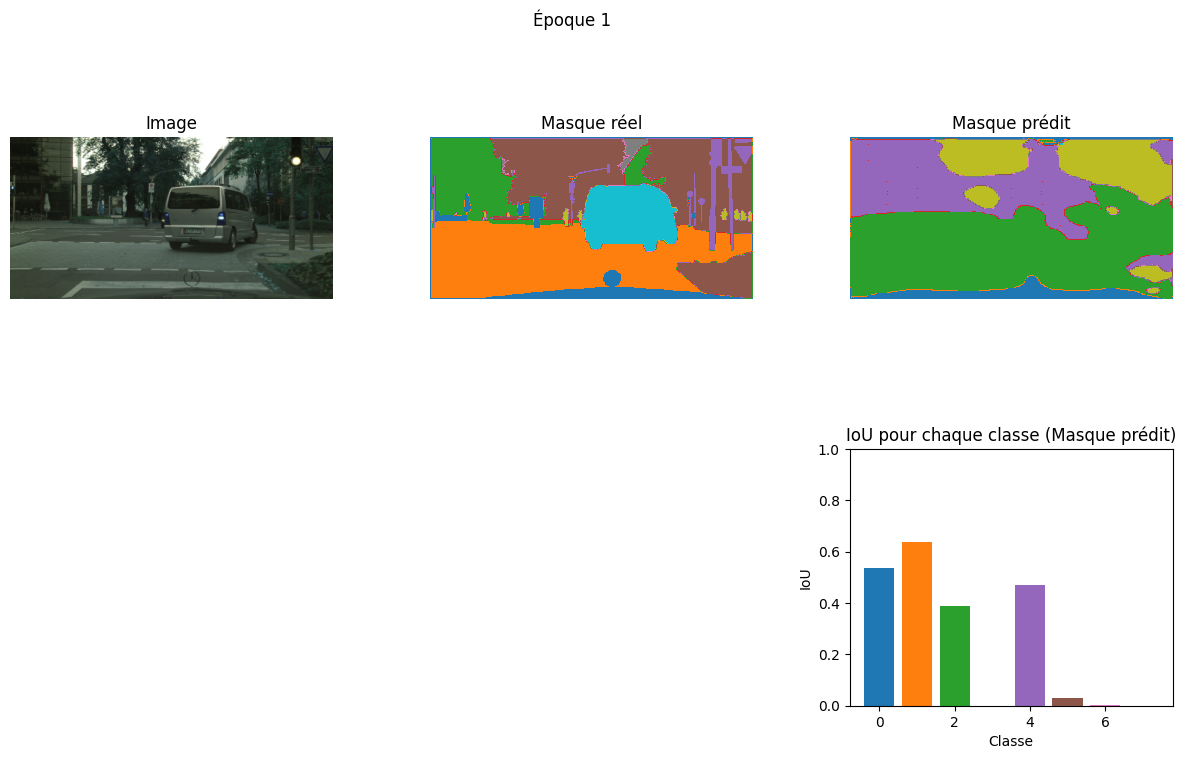

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.5350
Classe 1 : IoU = 0.6379
Classe 2 : IoU = 0.3872
Classe 3 : IoU = 0.0002
Classe 4 : IoU = 0.4723
Classe 5 : IoU = 0.0293
Classe 6 : IoU = 0.0011
Classe 7 : IoU = 0.0001
30/30 ━━━━━━━━━━━━━━━━━━━━ 544s 18s/step - accuracy: 0.6671 - dice_coeff: 0.5509 - dice_loss: 0.4491 - jaccard_score: 0.3821 - loss: 1.1562 - total_loss: 3.1901 - val_accuracy: 0.6376 - val_dice_coeff: 0.5169 - val_dice_loss: 0.4831 - val_jaccard_score: 0.3494 - val_loss: 1.0515 - val_total_loss: 2.6924
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.6840 - dice_coeff: 0.5634 - dice_loss: 0.4366 - jaccard_score: 0.3935 - loss: 0.9380 - total_loss: 2.6024 
Epoch 2: val_jaccard_score improved from 0.34940 to 0.45970, saving model to best_model_albumentations_1.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


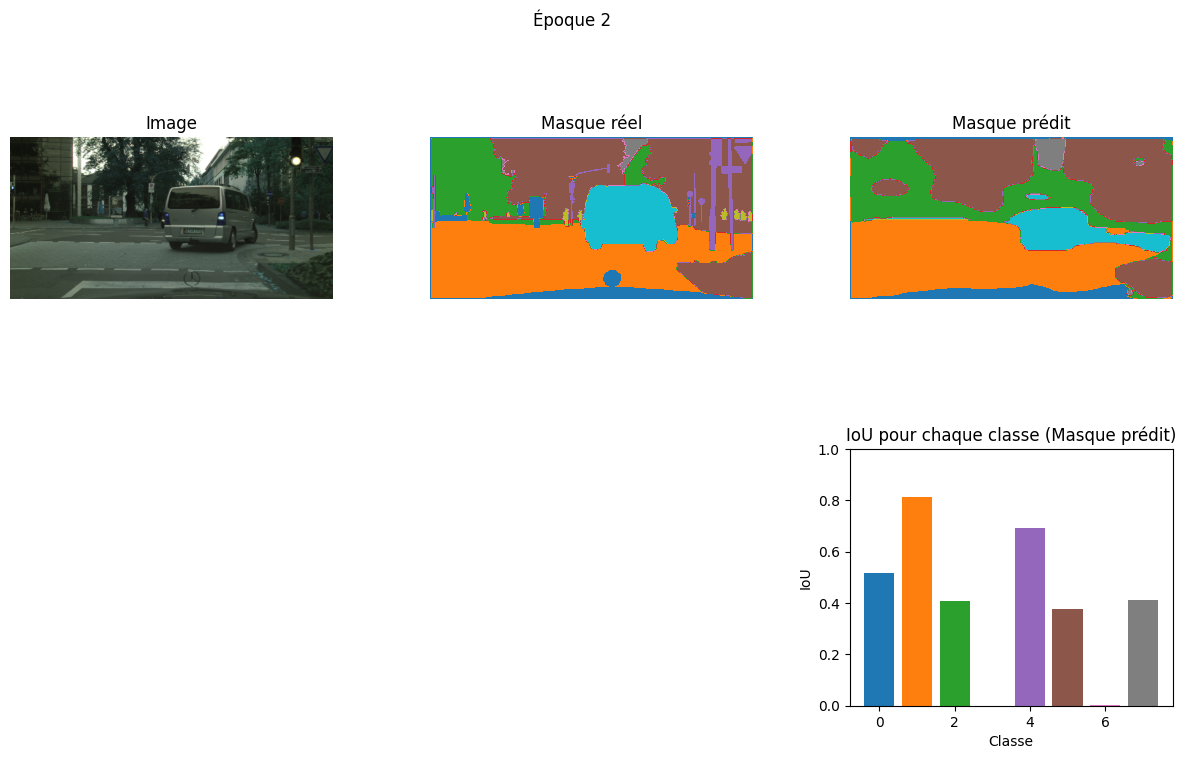

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.5166
Classe 1 : IoU = 0.8132
Classe 2 : IoU = 0.4067
Classe 3 : IoU = 0.0002
Classe 4 : IoU = 0.6922
Classe 5 : IoU = 0.3785
Classe 6 : IoU = 0.0011
Classe 7 : IoU = 0.4100
30/30 ━━━━━━━━━━━━━━━━━━━━ 542s 18s/step - accuracy: 0.6845 - dice_coeff: 0.5641 - dice_loss: 0.4359 - jaccard_score: 0.3941 - loss: 0.9367 - total_loss: 2.6047 - val_accuracy: 0.7274 - val_dice_coeff: 0.6292 - val_dice_loss: 0.3708 - val_jaccard_score: 0.4597 - val_loss: 0.9162 - val_total_loss: 3.2092
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.7614 - dice_coeff: 0.6576 - dice_loss: 0.3424 - jaccard_score: 0.4916 - loss: 0.7322 - total_loss: 2.7784 
Epoch 3: val_jaccard_score improved from 0.45970 to 0.47618, saving model to best_model_albumentations_1.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


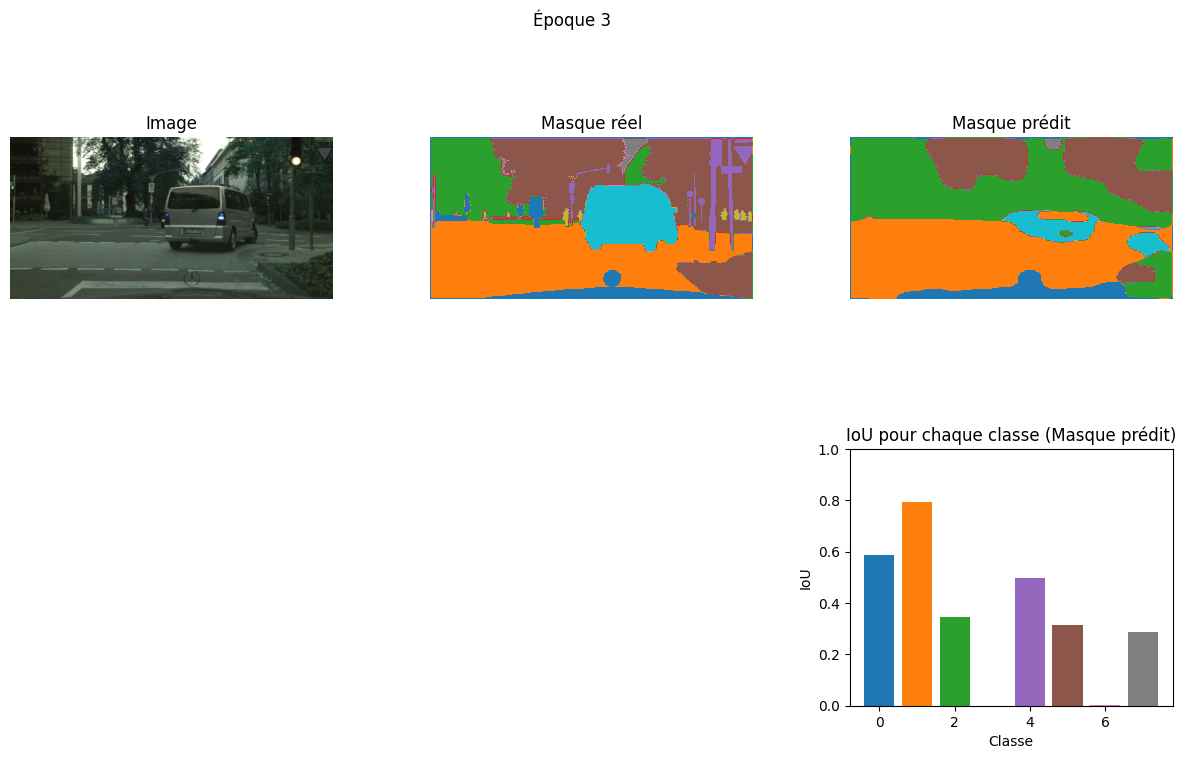

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.5865
Classe 1 : IoU = 0.7936
Classe 2 : IoU = 0.3438
Classe 3 : IoU = 0.0002
Classe 4 : IoU = 0.4964
Classe 5 : IoU = 0.3161
Classe 6 : IoU = 0.0011
Classe 7 : IoU = 0.2885
30/30 ━━━━━━━━━━━━━━━━━━━━ 543s 18s/step - accuracy: 0.7612 - dice_coeff: 0.6575 - dice_loss: 0.3425 - jaccard_score: 0.4914 - loss: 0.7327 - total_loss: 2.7742 - val_accuracy: 0.7365 - val_dice_coeff: 0.6446 - val_dice_loss: 0.3554 - val_jaccard_score: 0.4762 - val_loss: 0.7885 - val_total_loss: 2.7079
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.7667 - dice_coeff: 0.6662 - dice_loss: 0.3338 - jaccard_score: 0.5002 - loss: 0.7177 - total_loss: 2.6514 
Epoch 4: val_jaccard_score improved from 0.47618 to 0.53980, saving model to best_model_albumentations_1.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


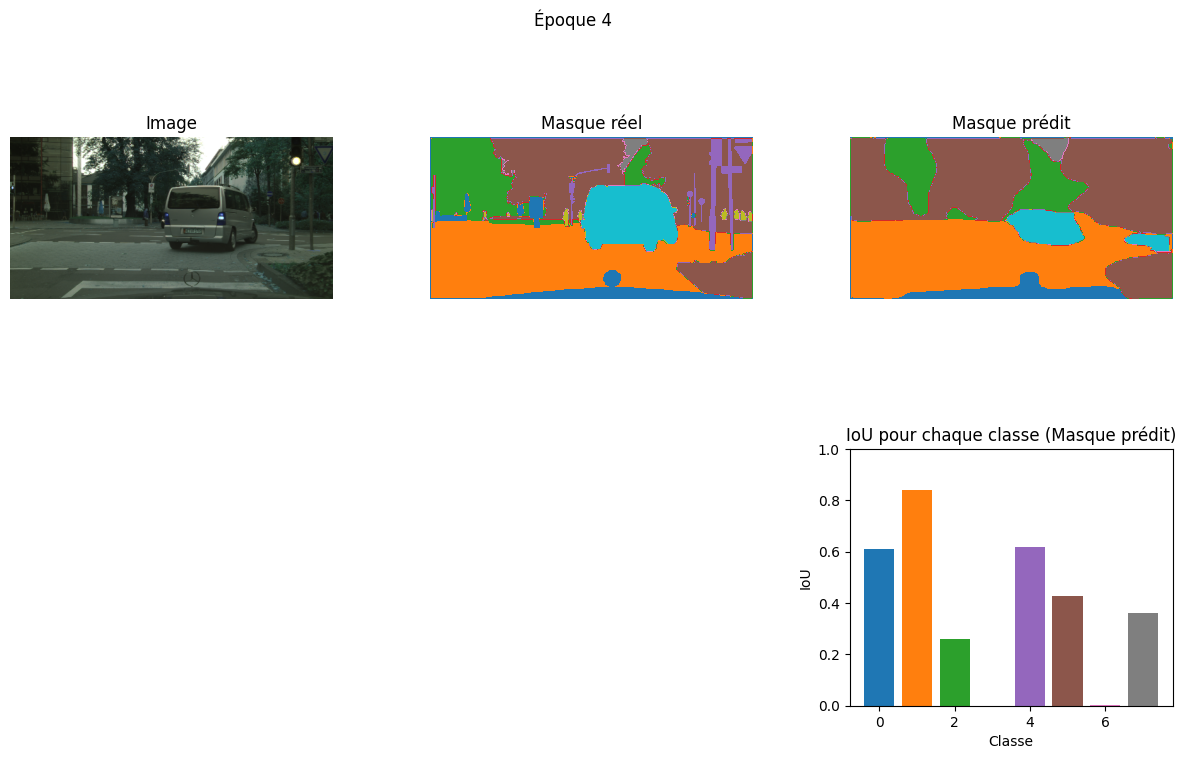

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.6098
Classe 1 : IoU = 0.8393
Classe 2 : IoU = 0.2592
Classe 3 : IoU = 0.0002
Classe 4 : IoU = 0.6182
Classe 5 : IoU = 0.4279
Classe 6 : IoU = 0.0011
Classe 7 : IoU = 0.3612
30/30 ━━━━━━━━━━━━━━━━━━━━ 544s 18s/step - accuracy: 0.7669 - dice_coeff: 0.6664 - dice_loss: 0.3336 - jaccard_score: 0.5004 - loss: 0.7172 - total_loss: 2.6498 - val_accuracy: 0.7729 - val_dice_coeff: 0.7007 - val_dice_loss: 0.2993 - val_jaccard_score: 0.5398 - val_loss: 0.7313 - val_total_loss: 2.6898
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [33]:
# Entraînement du modèle avec les données augmentées
history = model.fit(
    images_aug,
    masks_aug,
    batch_size=8,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint, PredictionCallback()]
)

#### Entraînement 2

In [34]:
filename = f"best_model_albumentations_2.keras"

# Définition du callback ModelCheckpoint 
model_checkpoint = ModelCheckpoint(
    filepath=filename,
    monitor='val_jaccard_score',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [35]:
# Utilisation de la fonction d'augmentation avec transformations supplémentaires avec albumentations
images_aug, masks_aug = augment_data_albumentations_extended(df_train_sample)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.6626 - dice_coeff: 0.5406 - dice_loss: 0.4594 - jaccard_score: 0.3718 - loss: 0.9985 - total_loss: 2.7401 
Epoch 1: val_jaccard_score improved from -inf to 0.45369, saving model to best_model_albumentations_2.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


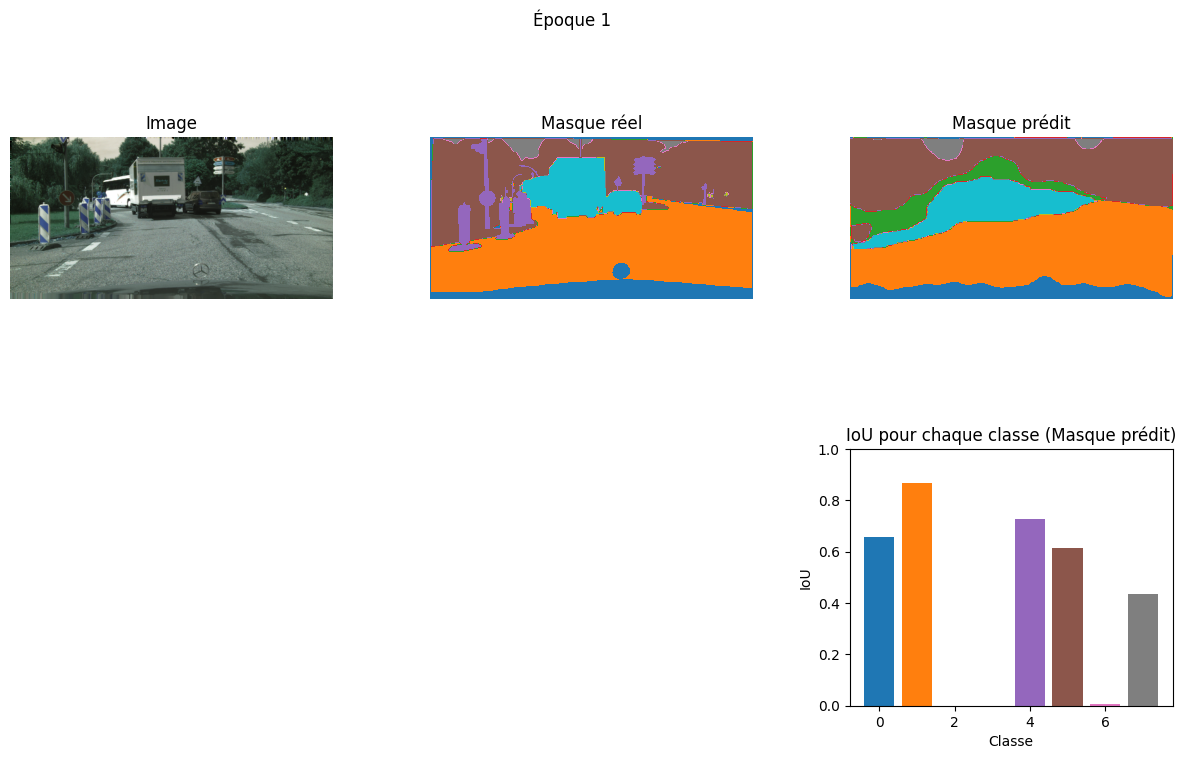

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.6573
Classe 1 : IoU = 0.8694
Classe 2 : IoU = 0.0001
Classe 3 : IoU = 0.0001
Classe 4 : IoU = 0.7276
Classe 5 : IoU = 0.6142
Classe 6 : IoU = 0.0079
Classe 7 : IoU = 0.4334
30/30 ━━━━━━━━━━━━━━━━━━━━ 562s 19s/step - accuracy: 0.6635 - dice_coeff: 0.5416 - dice_loss: 0.4584 - jaccard_score: 0.3728 - loss: 0.9964 - total_loss: 2.7398 - val_accuracy: 0.7385 - val_dice_coeff: 0.6234 - val_dice_loss: 0.3766 - val_jaccard_score: 0.4537 - val_loss: 0.8301 - val_total_loss: 2.6962
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.7508 - dice_coeff: 0.6400 - dice_loss: 0.3600 - jaccard_score: 0.4709 - loss: 0.7727 - total_loss: 2.6641 
Epoch 2: val_jaccard_score did not improve from 0.45369
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


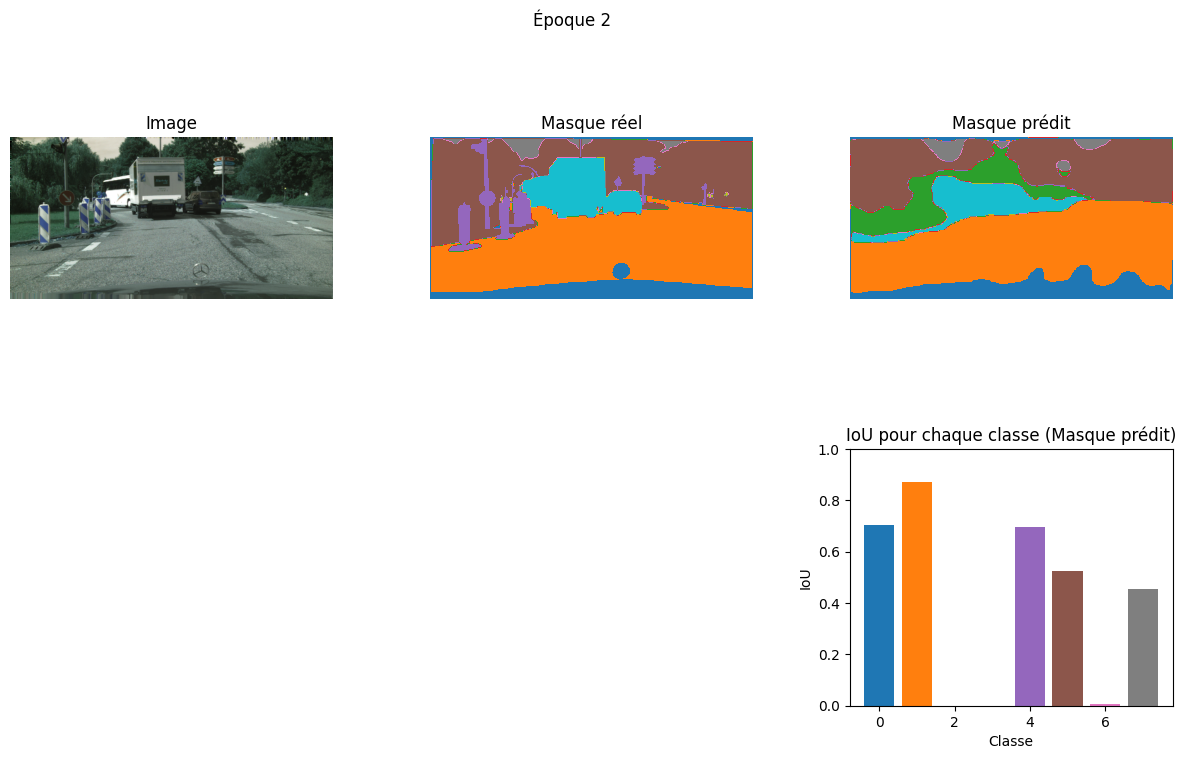

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.7051
Classe 1 : IoU = 0.8709
Classe 2 : IoU = 0.0001
Classe 3 : IoU = 0.0001
Classe 4 : IoU = 0.6966
Classe 5 : IoU = 0.5268
Classe 6 : IoU = 0.0079
Classe 7 : IoU = 0.4541
30/30 ━━━━━━━━━━━━━━━━━━━━ 550s 18s/step - accuracy: 0.7504 - dice_coeff: 0.6398 - dice_loss: 0.3602 - jaccard_score: 0.4708 - loss: 0.7736 - total_loss: 2.6665 - val_accuracy: 0.6984 - val_dice_coeff: 0.5397 - val_dice_loss: 0.4603 - val_jaccard_score: 0.3705 - val_loss: 0.9165 - val_total_loss: 2.7641
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.7235 - dice_coeff: 0.5858 - dice_loss: 0.4142 - jaccard_score: 0.4172 - loss: 0.8584 - total_loss: 2.5853 
Epoch 3: val_jaccard_score improved from 0.45369 to 0.48372, saving model to best_model_albumentations_2.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


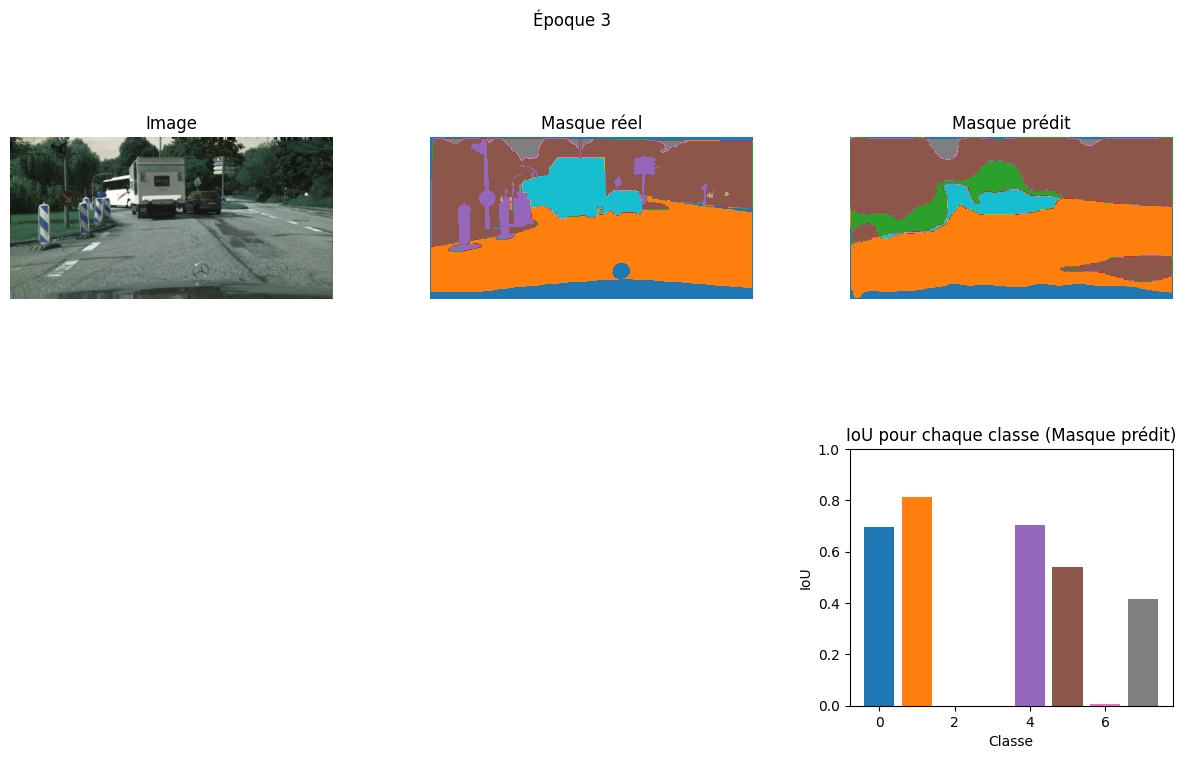

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.6970
Classe 1 : IoU = 0.8113
Classe 2 : IoU = 0.0001
Classe 3 : IoU = 0.0001
Classe 4 : IoU = 0.7052
Classe 5 : IoU = 0.5422
Classe 6 : IoU = 0.0079
Classe 7 : IoU = 0.4171
30/30 ━━━━━━━━━━━━━━━━━━━━ 561s 19s/step - accuracy: 0.7242 - dice_coeff: 0.5871 - dice_loss: 0.4129 - jaccard_score: 0.4186 - loss: 0.8562 - total_loss: 2.5837 - val_accuracy: 0.7471 - val_dice_coeff: 0.6508 - val_dice_loss: 0.3492 - val_jaccard_score: 0.4837 - val_loss: 0.7587 - val_total_loss: 2.4866
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.7619 - dice_coeff: 0.6648 - dice_loss: 0.3352 - jaccard_score: 0.4997 - loss: 0.7291 - total_loss: 2.4979 
Epoch 4: val_jaccard_score did not improve from 0.48372
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


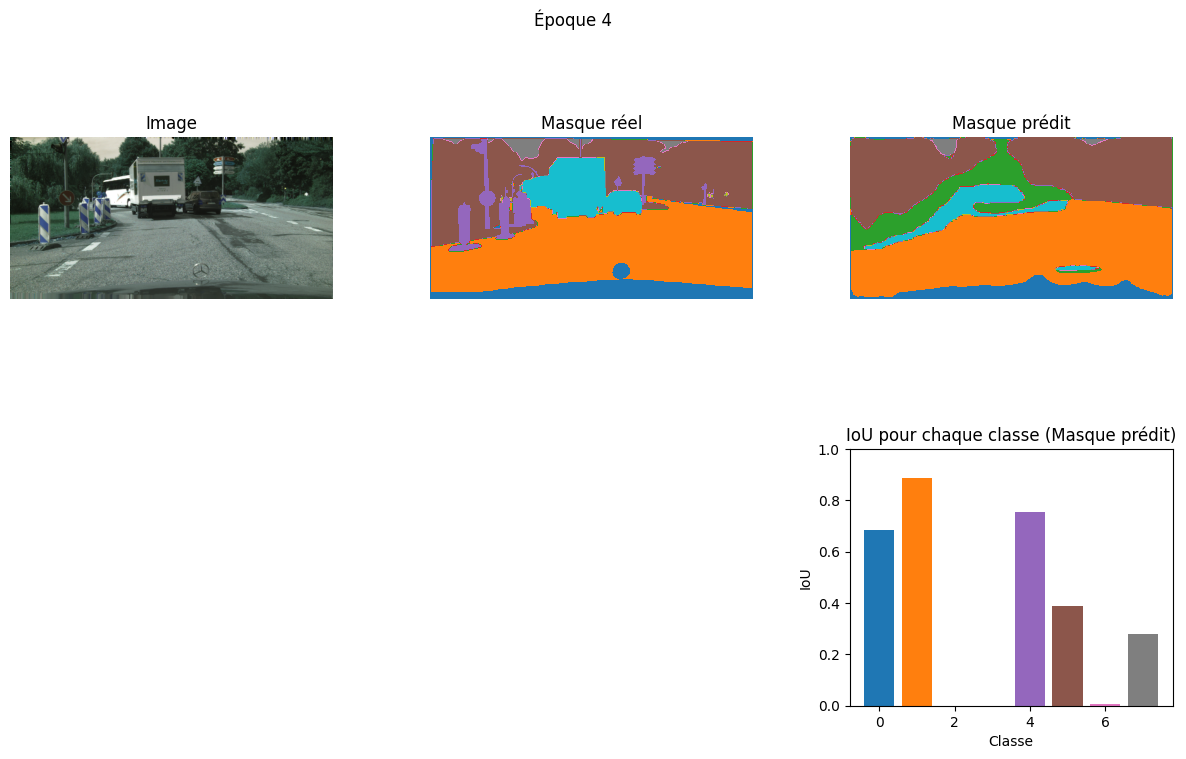

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.6829
Classe 1 : IoU = 0.8867
Classe 2 : IoU = 0.0001
Classe 3 : IoU = 0.0001
Classe 4 : IoU = 0.7533
Classe 5 : IoU = 0.3902
Classe 6 : IoU = 0.0079
Classe 7 : IoU = 0.2806
30/30 ━━━━━━━━━━━━━━━━━━━━ 543s 18s/step - accuracy: 0.7611 - dice_coeff: 0.6638 - dice_loss: 0.3362 - jaccard_score: 0.4986 - loss: 0.7309 - total_loss: 2.5012 - val_accuracy: 0.6835 - val_dice_coeff: 0.6007 - val_dice_loss: 0.3993 - val_jaccard_score: 0.4307 - val_loss: 0.9095 - val_total_loss: 3.0492
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [36]:
# Entraînement du modèle avec les données augmentées
history = model.fit(
    images_aug,
    masks_aug,
    batch_size=8,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint, PredictionCallback()]
)

## Avec TensorFlow

### Fonctions

In [37]:
# Fonction pour effectuer une rotation sans tensorflow-addons
def rotate_image_and_mask(image, mask, angle):
    # Calculer k, le nombre de rotations de 90 degrés à effectuer
    k = angle // 90
    image = tf.image.rot90(image, k=k)
    mask = tf.image.rot90(mask, k=k)
    return image, mask

In [38]:
# Fonction de data augmentation avec TensorFlow (sans tensorflow-addons)
def augment_data_tf(images, masks):
    def augment_image_and_mask(image, mask):
        # Flip horizontal avec probabilité de 50%
        image = tf.image.random_flip_left_right(image)
        mask = tf.image.random_flip_left_right(mask)

        # Flip vertical avec probabilité de 20%
        image = tf.image.random_flip_up_down(image)
        mask = tf.image.random_flip_up_down(mask)

        # Rotation aléatoire par multiples de 90 degrés
        angle = tf.random.uniform([], -90, 90, dtype=tf.int32)
        image, mask = rotate_image_and_mask(image, mask, angle)

        # Zoom de 80% à 120%
        scale = tf.random.uniform([], 0.8, 1.2)
        image = tf.image.resize(image, (int(256 * scale), int(512 * scale)))
        mask = tf.image.resize(mask, (int(256 * scale), int(512 * scale)))

        # Redimensionner pour la taille d'origine
        image = tf.image.resize(image, (256, 512))
        mask = tf.image.resize(mask, (256, 512))
        
        return image, mask

    # Appliquer la data augmentation
    images_aug = []
    masks_aug = []
    for img, msk in zip(images, masks):
        img_aug, msk_aug = augment_image_and_mask(img, msk)
        images_aug.append(img_aug)
        masks_aug.append(msk_aug)

    # Convertir en tensors de type tf.Tensor
    images_aug = tf.convert_to_tensor(images_aug)
    masks_aug = tf.convert_to_tensor(masks_aug)
    
    return images_aug, masks_aug

In [39]:
# Fonction avancée de data augmentation avec TensorFlow (sans tensorflow-addons)
def augment_data_tf_extended(images, masks):
    def augment_image_and_mask(image, mask):
        # Flip horizontal avec probabilité de 50%
        image = tf.image.random_flip_left_right(image)
        mask = tf.image.random_flip_left_right(mask)

        # Flip vertical avec probabilité de 20%
        image = tf.image.random_flip_up_down(image)
        mask = tf.image.random_flip_up_down(mask)

        # Rotation aléatoire par multiples de 90 degrés
        angle = tf.random.uniform([], -90, 90, dtype=tf.int32)
        image, mask = rotate_image_and_mask(image, mask, angle)

        # Zoom de 80% à 120%
        scale = tf.random.uniform([], 0.8, 1.2)
        image = tf.image.resize(image, (int(256 * scale), int(512 * scale)))
        mask = tf.image.resize(mask, (int(256 * scale), int(512 * scale)))

        # Redimensionner pour la taille d'origine
        image = tf.image.resize(image, (256, 512))
        mask = tf.image.resize(mask, (256, 512))

        # Ajout de transformations supplémentaires

        # Ajuste la luminosité
        image = tf.image.random_brightness(image, max_delta=0.2)  # delta de luminosité max de 20%

        # Ajuste le contraste
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Contraste entre 80% et 120%

        # Ajuste la saturation (pour les images en couleur)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)  # Saturation entre 80% et 120%

        # Ajuste la teinte
        image = tf.image.random_hue(image, max_delta=0.1)  # Variation de teinte max de 10%

        return image, mask

    # Appliquer la data augmentation
    images_aug = []
    masks_aug = []
    for img, msk in zip(images, masks):
        img_aug, msk_aug = augment_image_and_mask(img, msk)
        images_aug.append(img_aug)
        masks_aug.append(msk_aug)

    # Convertir en tensors de type tf.Tensor
    images_aug = tf.convert_to_tensor(images_aug)
    masks_aug = tf.convert_to_tensor(masks_aug)
    
    return images_aug, masks_aug

### Entraînement du modèle

In [40]:
# Chargement des images et masques
images = load_images(df_train_sample)
masks = load_masks(df_train_sample)

#### Entraînement 1

In [41]:
filename = f"best_model_tensorflow_1.keras"

# Définition du callback ModelCheckpoint 
model_checkpoint = ModelCheckpoint(
    filepath=filename,
    monitor='val_jaccard_score',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [42]:
# Appliquer la data augmentation
images_aug, masks_aug = augment_data_tf(images, masks)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.3774 - dice_coeff: 0.2680 - dice_loss: 0.7320 - jaccard_score: 0.1555 - loss: 1.7843 - total_loss: 3.3722 
Epoch 1: val_jaccard_score improved from -inf to 0.15423, saving model to best_model_tensorflow_1.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


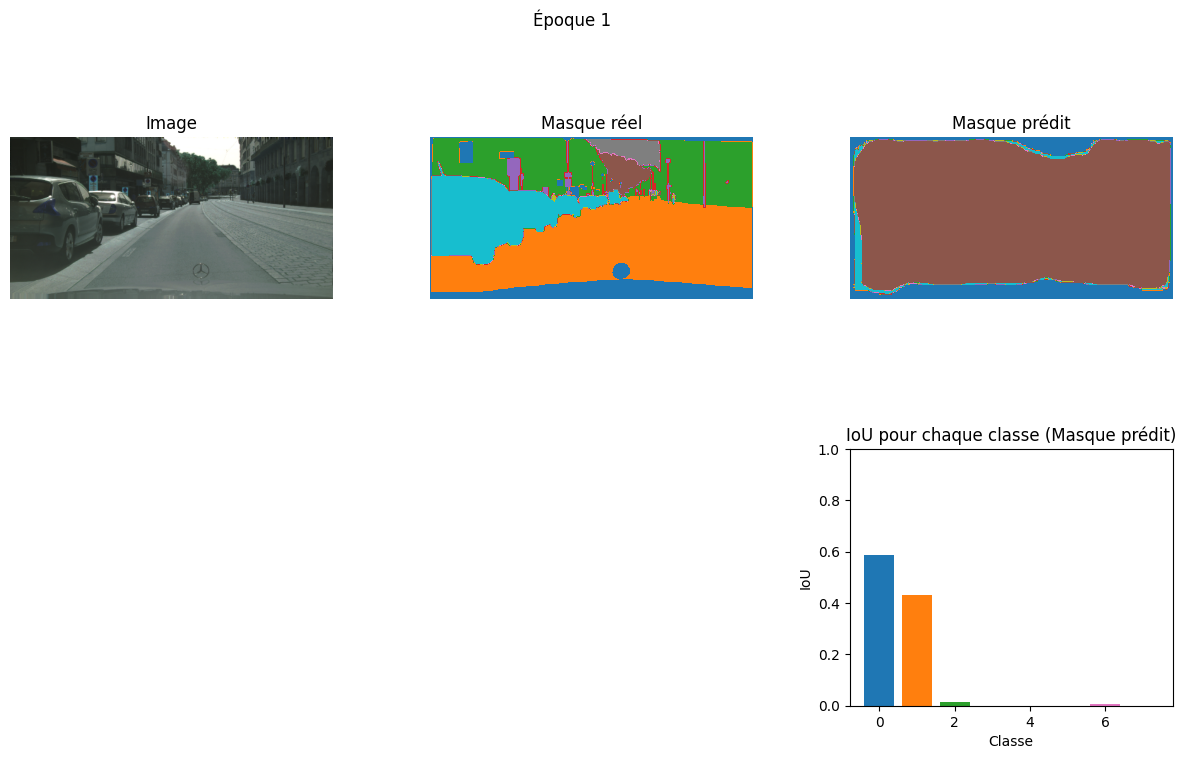

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.5874
Classe 1 : IoU = 0.4310
Classe 2 : IoU = 0.0142
Classe 3 : IoU = 0.0004
Classe 4 : IoU = 0.0003
Classe 5 : IoU = 0.0003
Classe 6 : IoU = 0.0068
Classe 7 : IoU = 0.0000
30/30 ━━━━━━━━━━━━━━━━━━━━ 553s 19s/step - accuracy: 0.3781 - dice_coeff: 0.2680 - dice_loss: 0.7320 - jaccard_score: 0.1554 - loss: 1.7802 - total_loss: 3.3688 - val_accuracy: 0.3931 - val_dice_coeff: 0.2672 - val_dice_loss: 0.7328 - val_jaccard_score: 0.1542 - val_loss: 1.6166 - val_total_loss: 3.1603
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.4220 - dice_coeff: 0.2824 - dice_loss: 0.7176 - jaccard_score: 0.1645 - loss: 1.5464 - total_loss: 3.0937 
Epoch 2: val_jaccard_score improved from 0.15423 to 0.15701, saving model to best_model_tensorflow_1.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


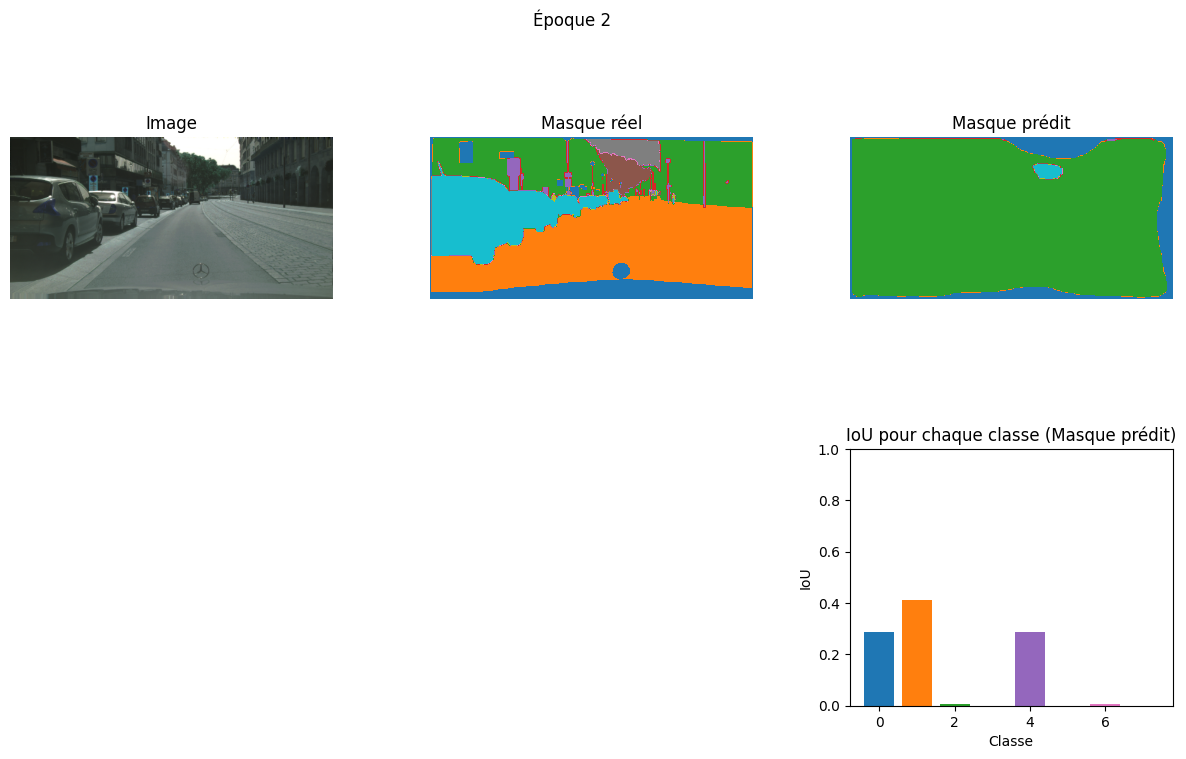

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.2891
Classe 1 : IoU = 0.4102
Classe 2 : IoU = 0.0050
Classe 3 : IoU = 0.0004
Classe 4 : IoU = 0.2857
Classe 5 : IoU = 0.0003
Classe 6 : IoU = 0.0068
Classe 7 : IoU = 0.0000
30/30 ━━━━━━━━━━━━━━━━━━━━ 550s 18s/step - accuracy: 0.4219 - dice_coeff: 0.2823 - dice_loss: 0.7177 - jaccard_score: 0.1644 - loss: 1.5465 - total_loss: 3.0936 - val_accuracy: 0.3926 - val_dice_coeff: 0.2714 - val_dice_loss: 0.7286 - val_jaccard_score: 0.1570 - val_loss: 1.6104 - val_total_loss: 3.1629
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.4372 - dice_coeff: 0.2864 - dice_loss: 0.7136 - jaccard_score: 0.1672 - loss: 1.5242 - total_loss: 3.0857 
Epoch 3: val_jaccard_score improved from 0.15701 to 0.17167, saving model to best_model_tensorflow_1.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


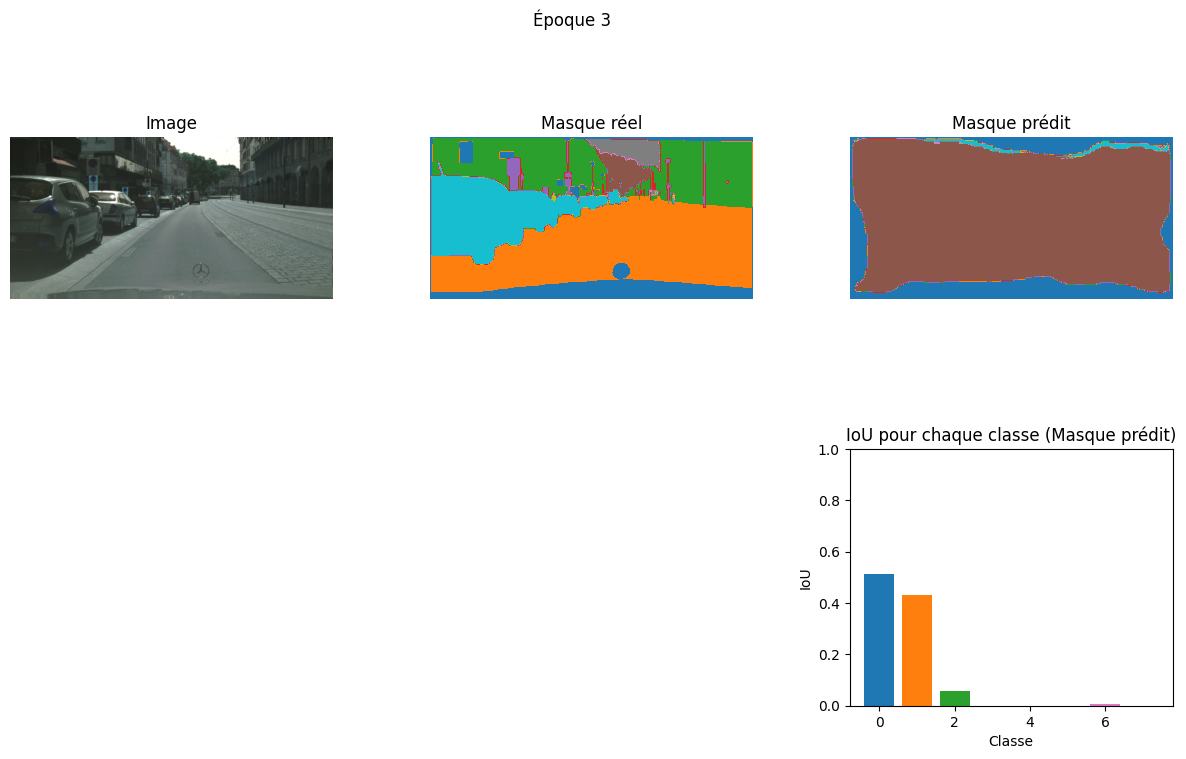

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.5148
Classe 1 : IoU = 0.4324
Classe 2 : IoU = 0.0579
Classe 3 : IoU = 0.0004
Classe 4 : IoU = 0.0003
Classe 5 : IoU = 0.0003
Classe 6 : IoU = 0.0068
Classe 7 : IoU = 0.0000
30/30 ━━━━━━━━━━━━━━━━━━━━ 532s 18s/step - accuracy: 0.4369 - dice_coeff: 0.2864 - dice_loss: 0.7136 - jaccard_score: 0.1672 - loss: 1.5241 - total_loss: 3.0855 - val_accuracy: 0.4053 - val_dice_coeff: 0.2930 - val_dice_loss: 0.7070 - val_jaccard_score: 0.1717 - val_loss: 1.5777 - val_total_loss: 3.1120
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.4319 - dice_coeff: 0.2971 - dice_loss: 0.7029 - jaccard_score: 0.1746 - loss: 1.4933 - total_loss: 3.0645 
Epoch 4: val_jaccard_score did not improve from 0.17167
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


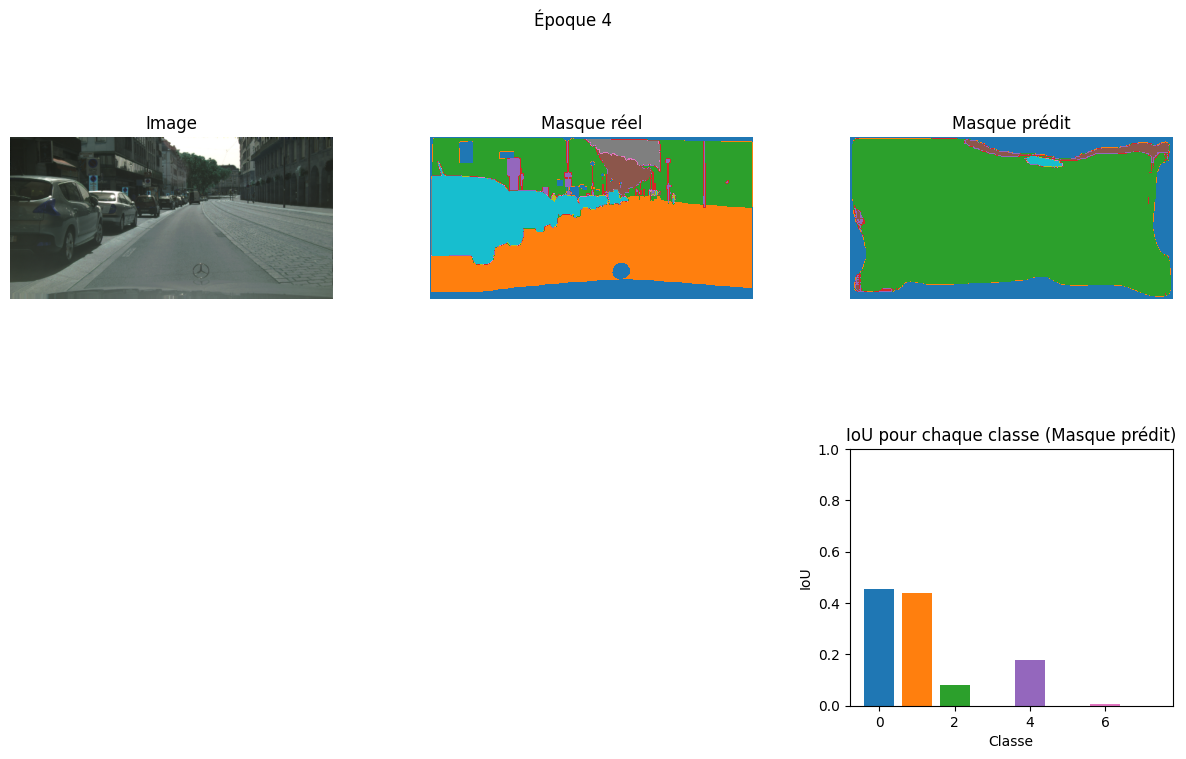

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.4529
Classe 1 : IoU = 0.4388
Classe 2 : IoU = 0.0808
Classe 3 : IoU = 0.0004
Classe 4 : IoU = 0.1780
Classe 5 : IoU = 0.0003
Classe 6 : IoU = 0.0068
Classe 7 : IoU = 0.0000
30/30 ━━━━━━━━━━━━━━━━━━━━ 533s 18s/step - accuracy: 0.4319 - dice_coeff: 0.2970 - dice_loss: 0.7030 - jaccard_score: 0.1745 - loss: 1.4935 - total_loss: 3.0650 - val_accuracy: 0.4054 - val_dice_coeff: 0.2769 - val_dice_loss: 0.7231 - val_jaccard_score: 0.1607 - val_loss: 1.5438 - val_total_loss: 3.1241
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [43]:
# Entraînement du modèle avec les données augmentées
history = model.fit(
    images_aug,
    masks_aug,
    batch_size=8,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint, PredictionCallback()]
)

#### Entraînement 2

In [44]:
filename = f"best_model_tensorflow_2.keras"

# Définition du callback ModelCheckpoint 
model_checkpoint = ModelCheckpoint(
    filepath=filename,
    monitor='val_jaccard_score',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [45]:
images_aug, masks_aug = augment_data_tf_extended(images, masks)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.4207 - dice_coeff: 0.2773 - dice_loss: 0.7227 - jaccard_score: 0.1610 - loss: 1.5518 - total_loss: 3.1174 
Epoch 1: val_jaccard_score improved from -inf to 0.14942, saving model to best_model_tensorflow_2.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


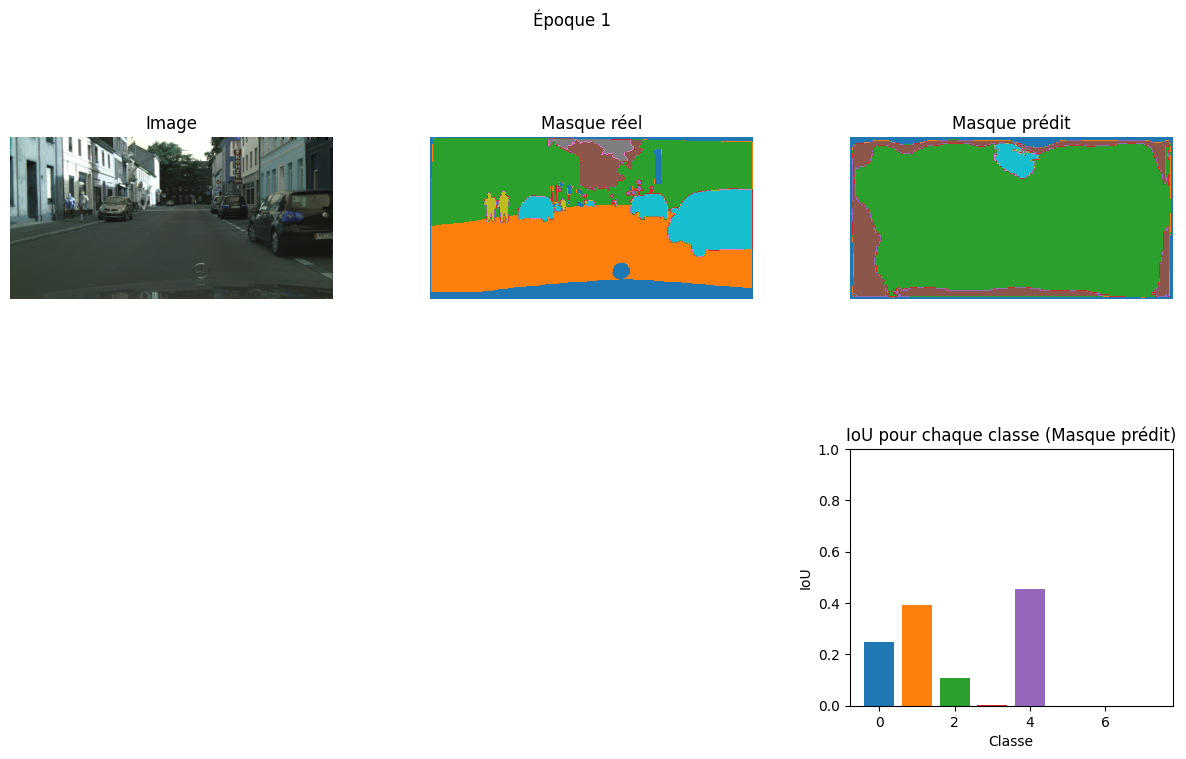

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.2499
Classe 1 : IoU = 0.3908
Classe 2 : IoU = 0.1079
Classe 3 : IoU = 0.0024
Classe 4 : IoU = 0.4553
Classe 5 : IoU = 0.0005
Classe 6 : IoU = 0.0008
Classe 7 : IoU = 0.0001
30/30 ━━━━━━━━━━━━━━━━━━━━ 538s 18s/step - accuracy: 0.4206 - dice_coeff: 0.2773 - dice_loss: 0.7227 - jaccard_score: 0.1610 - loss: 1.5518 - total_loss: 3.1171 - val_accuracy: 0.3910 - val_dice_coeff: 0.2599 - val_dice_loss: 0.7401 - val_jaccard_score: 0.1494 - val_loss: 1.5776 - val_total_loss: 3.0984
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.4235 - dice_coeff: 0.2824 - dice_loss: 0.7176 - jaccard_score: 0.1645 - loss: 1.5393 - total_loss: 3.0770 
Epoch 2: val_jaccard_score improved from 0.14942 to 0.16038, saving model to best_model_tensorflow_2.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


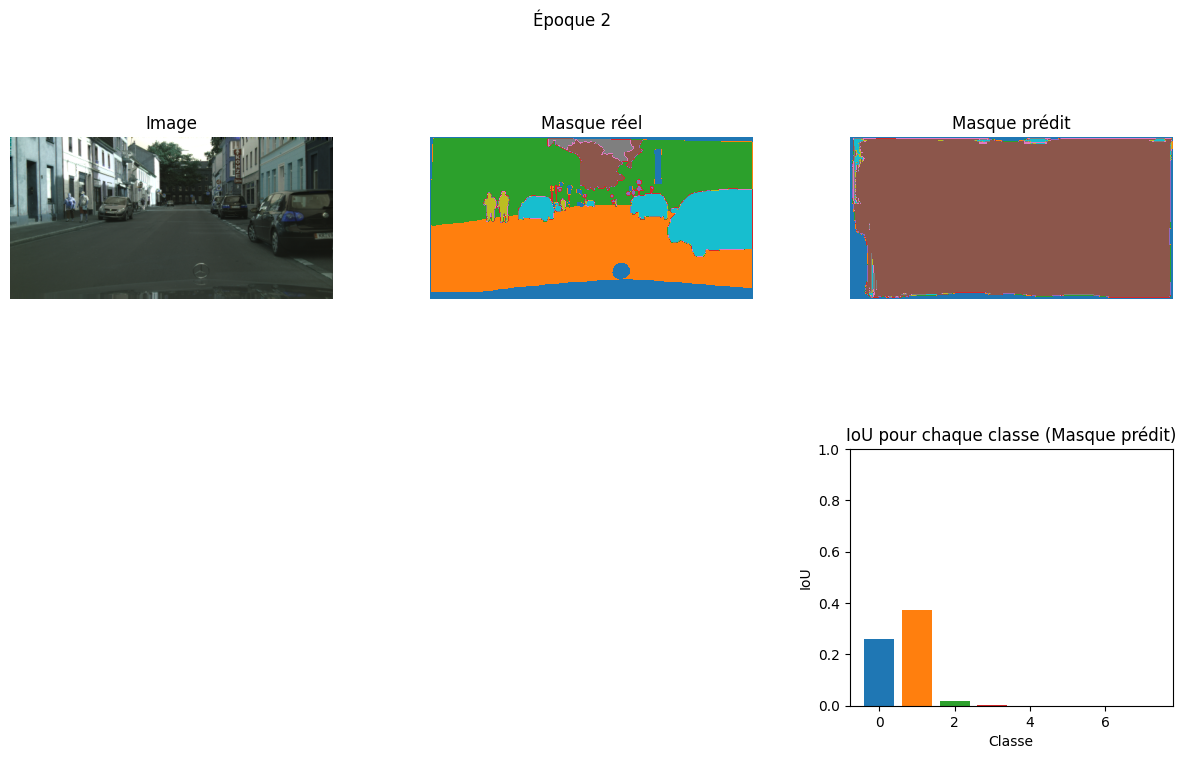

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.2587
Classe 1 : IoU = 0.3737
Classe 2 : IoU = 0.0187
Classe 3 : IoU = 0.0024
Classe 4 : IoU = 0.0002
Classe 5 : IoU = 0.0005
Classe 6 : IoU = 0.0008
Classe 7 : IoU = 0.0001
30/30 ━━━━━━━━━━━━━━━━━━━━ 531s 18s/step - accuracy: 0.4234 - dice_coeff: 0.2823 - dice_loss: 0.7177 - jaccard_score: 0.1644 - loss: 1.5396 - total_loss: 3.0772 - val_accuracy: 0.3971 - val_dice_coeff: 0.2764 - val_dice_loss: 0.7236 - val_jaccard_score: 0.1604 - val_loss: 1.6020 - val_total_loss: 3.1094
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.4215 - dice_coeff: 0.2811 - dice_loss: 0.7189 - jaccard_score: 0.1636 - loss: 1.5345 - total_loss: 3.0701 
Epoch 3: val_jaccard_score did not improve from 0.16038
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


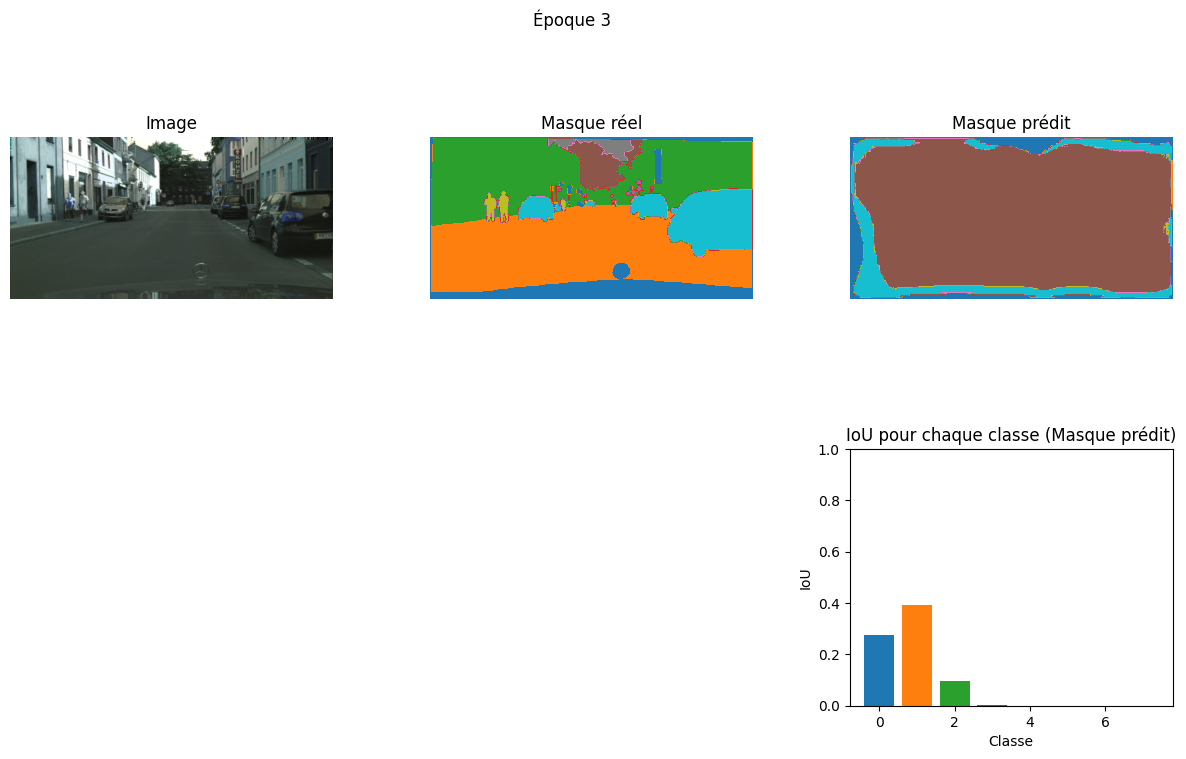

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.2743
Classe 1 : IoU = 0.3917
Classe 2 : IoU = 0.0964
Classe 3 : IoU = 0.0024
Classe 4 : IoU = 0.0002
Classe 5 : IoU = 0.0005
Classe 6 : IoU = 0.0008
Classe 7 : IoU = 0.0001
30/30 ━━━━━━━━━━━━━━━━━━━━ 549s 18s/step - accuracy: 0.4216 - dice_coeff: 0.2812 - dice_loss: 0.7188 - jaccard_score: 0.1636 - loss: 1.5343 - total_loss: 3.0698 - val_accuracy: 0.4027 - val_dice_coeff: 0.2751 - val_dice_loss: 0.7249 - val_jaccard_score: 0.1595 - val_loss: 1.5802 - val_total_loss: 3.1025
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.4290 - dice_coeff: 0.2882 - dice_loss: 0.7118 - jaccard_score: 0.1684 - loss: 1.5073 - total_loss: 3.0588 
Epoch 4: val_jaccard_score improved from 0.16038 to 0.16139, saving model to best_model_tensorflow_2.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


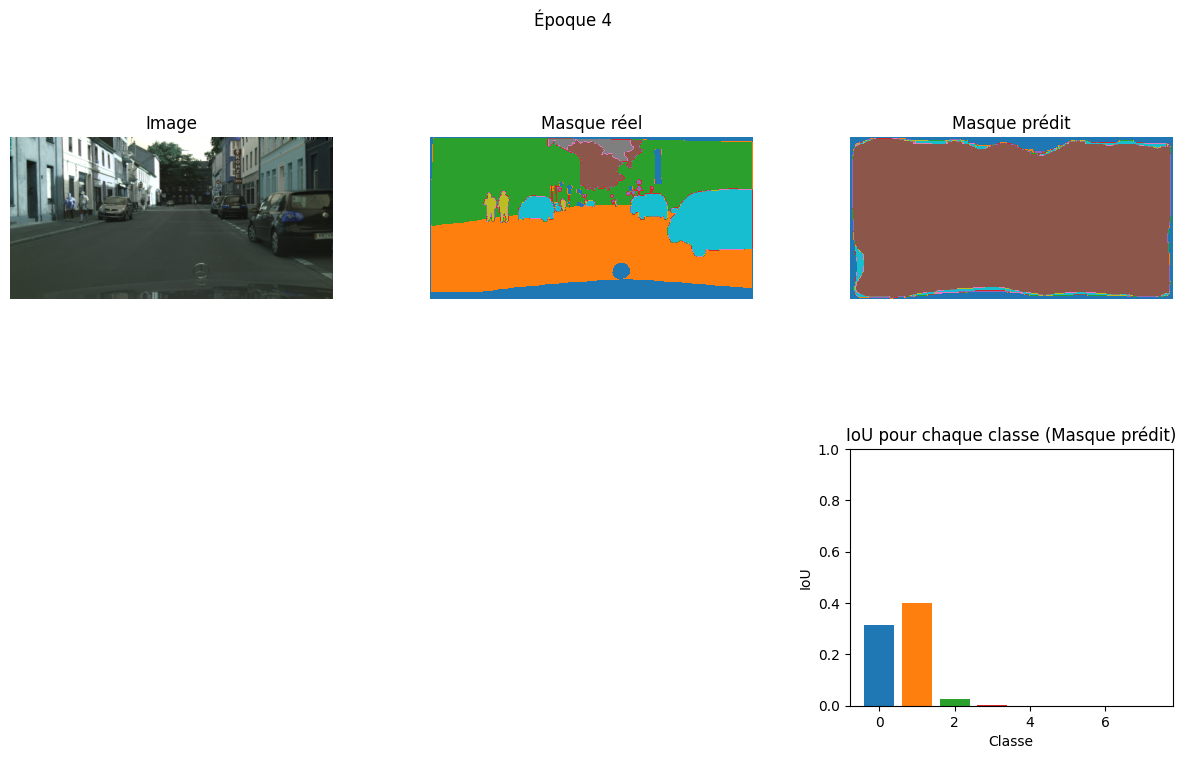

IoU pour chaque classe (Masque prédit) :
Classe 0 : IoU = 0.3140
Classe 1 : IoU = 0.4006
Classe 2 : IoU = 0.0260
Classe 3 : IoU = 0.0024
Classe 4 : IoU = 0.0002
Classe 5 : IoU = 0.0005
Classe 6 : IoU = 0.0008
Classe 7 : IoU = 0.0001
30/30 ━━━━━━━━━━━━━━━━━━━━ 532s 18s/step - accuracy: 0.4289 - dice_coeff: 0.2881 - dice_loss: 0.7119 - jaccard_score: 0.1683 - loss: 1.5076 - total_loss: 3.0592 - val_accuracy: 0.4055 - val_dice_coeff: 0.2779 - val_dice_loss: 0.7221 - val_jaccard_score: 0.1614 - val_loss: 1.5564 - val_total_loss: 3.0871
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [46]:
# Entraînement du modèle avec les données augmentées
history = model.fit(
    images_aug,
    masks_aug,
    batch_size=8,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint, PredictionCallback()]
)